<a href="https://colab.research.google.com/github/AO811/Healthcare-Analytics-Research-Paper-Project/blob/main/Healthcare_Analytics_Data_Mining_Techniques_on_Electronic_Health_Records_(EHR)_to_Build_a_Predictive_Model_for_Early_Disease_Diagnosisipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Cell 1 — run once
# (installs iterative-stratification for multilabel stratified splitting)
!pip install -q iterative-stratification

# Imports
import os
import numpy as np
import pandas as pd
from IPython.display import display

# Modeling & preprocessing
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, confusion_matrix, classification_report
from sklearn.model_selection import RandomizedSearchCV

# Multilabel stratified split
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit, MultilabelStratifiedKFold

import joblib
import warnings
warnings.filterwarnings("ignore")
print("Setup done.")


Setup done.


In [ ]:
# Cell 2 (Option A)
from google.colab import files
uploaded = files.upload()  # a widget will pop up; select all your files
print("Uploaded:", list(uploaded.keys()))


Saving Cancer_Data.csv to Cancer_Data.csv
Uploaded: ['Cancer_Data.csv']


In [ ]:
# Cell 3 — Read the datasets (adjust filenames if needed)

data_files = {
    "heart": "processed_cleveland.csv",
    "diabetes": "diabetes.csv",
    "ckd": "kidney_disease.csv",
    "breast": "breast-cancer-wisconsin.data",
    "cancer2": "Cancer_Data.csv",
    "lung_survey": "survey lung cancer.csv"
}

datasets = {}
for key, fname in data_files.items():
    if not os.path.exists(fname):
        print(f"WARNING: {fname} not found in working directory.")
        datasets[key] = None
        continue
    if key == "breast":
        # UCI breast-cancer-wisconsin has no header
        df = pd.read_csv(fname, header=None)
        # Standard column names for the classic breast dataset (UCI)
        cols = ['id','clump_thickness','cell_size','cell_shape','marginal_adhesion',
                'single_epithelial_cell_size','bare_nuclei','bland_chromatin','normal_nucleoli','mitoses','class']
        if df.shape[1] == len(cols):
            df.columns = cols
    else:
        try:
            df = pd.read_csv(fname)
        except Exception as e:
            print(f"Error reading {fname}: {e}")
            df = None
    datasets[key] = df
    print(f">>> {key} loaded. shape:", None if df is None else df.shape)
    display(df.head(2))


>>> heart loaded. shape: (303, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63,1,1,145,233,1,2,150,0,2.3,3,0,6,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,3,2


>>> diabetes loaded. shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0


>>> ckd loaded. shape: (400, 26)


,id,age,bp,sg,al,su,rbc,pc,pcc,ba,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,0,48.0,80.0,1.02,1.0,0.0,NaN,normal,notpresent,notpresent,...,44,7800,5.2,yes,yes,no,good,no,no,ckd
1,1,7.0,50.0,1.02,4.0,0.0,NaN,normal,notpresent,notpresent,...,38,6000,NaN,no,no,no,good,no,no,ckd


>>> breast loaded. shape: (699, 11)


,id,clump_thickness,cell_size,cell_shape,marginal_adhesion,single_epithelial_cell_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses,class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2


>>> cancer2 loaded. shape: (569, 33)


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN


>>> lung_survey loaded. shape: (309, 16)


,GENDER,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL CONSUMING,COUGHING,SHORTNESS OF BREATH,SWALLOWING DIFFICULTY,CHEST PAIN,LUNG_CANCER
0,M,69,1,2,2,1,1,2,1,2,2,2,2,2,2,YES
1,M,74,2,1,1,1,2,2,2,1,1,1,2,2,2,YES


In [ ]:
# Step 3 — Standardize column names and add disease labels

def clean_columns(df):
    """Standardize column names: lowercase, replace spaces with '_', remove special chars"""
    df.columns = (
        df.columns.str.strip()
                  .str.lower()
                  .str.replace(' ', '_')
                  .str.replace('-', '_')
                  .str.replace('.', '_')
    )
    return df

cleaned_datasets = {}

for key, df in datasets.items():
    if df is None:
        continue

    # Clean column names
    df = clean_columns(df)

    # Add disease label
    if key == "heart":
        df["disease_label"] = "heart"
    elif key == "diabetes":
        df["disease_label"] = "diabetes"
    elif key == "ckd":
        df["disease_label"] = "ckd"
    elif key == "breast":
        df["disease_label"] = "breast_cancer"
    elif key == "cancer2":
        df["disease_label"] = "breast_cancer2"
    elif key == "lung_survey":
        df["disease_label"] = "lung_cancer"

    cleaned_datasets[key] = df
    print(f">>> {key} cleaned. Columns: {list(df.columns)[:10]} ... + disease_label")

# Preview one row from each
for key, df in cleaned_datasets.items():
    print("\nDataset:", key)
    display(df.head(1))


>>> heart cleaned. Columns: ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak'] ... + disease_label
>>> diabetes cleaned. Columns: ['pregnancies', 'glucose', 'bloodpressure', 'skinthickness', 'insulin', 'bmi', 'diabetespedigreefunction', 'age', 'outcome', 'disease_label'] ... + disease_label
>>> ckd cleaned. Columns: ['id', 'age', 'bp', 'sg', 'al', 'su', 'rbc', 'pc', 'pcc', 'ba'] ... + disease_label
>>> breast cleaned. Columns: ['id', 'clump_thickness', 'cell_size', 'cell_shape', 'marginal_adhesion', 'single_epithelial_cell_size', 'bare_nuclei', 'bland_chromatin', 'normal_nucleoli', 'mitoses'] ... + disease_label
>>> cancer2 cleaned. Columns: ['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave_points_mean'] ... + disease_label
>>> lung_survey cleaned. Columns: ['gender', 'age', 'smoking', 'yellow_fingers', 'anxiety', 'peer_pressure', 'chronic_disease', '

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,disease_label
0,63,1,1,145,233,1,2,150,0,2.3,3,0,6,0,heart



Dataset: diabetes


,pregnancies,glucose,bloodpressure,skinthickness,insulin,bmi,diabetespedigreefunction,age,outcome,disease_label
0,6,148,72,35,0,33.6,0.627,50,1,diabetes



Dataset: ckd


,id,age,bp,sg,al,su,rbc,pc,pcc,ba,...,wc,rc,htn,dm,cad,appet,pe,ane,classification,disease_label
0,0,48.0,80.0,1.02,1.0,0.0,NaN,normal,notpresent,notpresent,...,7800,5.2,yes,yes,no,good,no,no,ckd,ckd



Dataset: breast


,id,clump_thickness,cell_size,cell_shape,marginal_adhesion,single_epithelial_cell_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses,class,disease_label
0,1000025,5,1,1,1,2,1,3,1,1,2,breast_cancer



Dataset: cancer2


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,...,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst,unnamed:_32,disease_label
0,842302,M,17.99,10.38,122.8,1001.0,0.1184,0.2776,0.3001,0.1471,...,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.1189,NaN,breast_cancer2



Dataset: lung_survey


,gender,age,smoking,yellow_fingers,anxiety,peer_pressure,chronic_disease,fatigue,allergy,wheezing,alcohol_consuming,coughing,shortness_of_breath,swallowing_difficulty,chest_pain,lung_cancer,disease_label
0,M,69,1,2,2,1,1,2,1,2,2,2,2,2,2,YES,lung_cancer


In [ ]:
# Step 4 — Standardize target column across datasets

targeted_datasets = {}

for key, df in cleaned_datasets.items():
    df = df.copy()

    if key == "heart":
        # 'num' > 0 means heart disease present
        df["target"] = (df["num"] > 0).astype(int)
        df.drop(columns=["num"], inplace=True)

    elif key == "diabetes":
        # 'outcome' is already 0 or 1
        df["target"] = df["outcome"]
        df.drop(columns=["outcome"], inplace=True)

    elif key == "ckd":
        # 'classification' is 'ckd' or 'notckd'
        df["target"] = df["classification"].map(lambda x: 1 if str(x).lower().startswith("ckd") else 0)
        df.drop(columns=["classification"], inplace=True)

    elif key == "breast":
        # 'class' is 2 (benign) or 4 (malignant)
        df["target"] = df["class"].map(lambda x: 1 if x == 4 else 0)
        df.drop(columns=["class"], inplace=True)

    elif key == "cancer2":
        # 'diagnosis' is 'M' (malignant) or 'B' (benign)
        df["target"] = df["diagnosis"].map(lambda x: 1 if str(x).upper() == "M" else 0)
        df.drop(columns=["diagnosis"], inplace=True)

    elif key == "lung_survey":
        # 'lung_cancer' is 'YES'/'NO'
        df["target"] = df["lung_cancer"].map(lambda x: 1 if str(x).upper() == "YES" else 0)
        df.drop(columns=["lung_cancer"], inplace=True)

    targeted_datasets[key] = df
    print(f">>> {key} standardized. Target distribution:")
    print(df["target"].value_counts())

# Preview
for key, df in targeted_datasets.items():
    print("\nDataset:", key)
    display(df[["disease_label", "target"]].head(3))


>>> heart standardized. Target distribution:
target
0    164
1    139
Name: count, dtype: int64
>>> diabetes standardized. Target distribution:
target
0    500
1    268
Name: count, dtype: int64
>>> ckd standardized. Target distribution:
target
1    250
0    150
Name: count, dtype: int64
>>> breast standardized. Target distribution:
target
0    458
1    241
Name: count, dtype: int64
>>> cancer2 standardized. Target distribution:
target
0    357
1    212
Name: count, dtype: int64
>>> lung_survey standardized. Target distribution:
target
1    270
0     39
Name: count, dtype: int64

Dataset: heart


,disease_label,target
0,heart,0
1,heart,1
2,heart,1



Dataset: diabetes


,disease_label,target
0,diabetes,1
1,diabetes,0
2,diabetes,1



Dataset: ckd


,disease_label,target
0,ckd,1
1,ckd,1
2,ckd,1



Dataset: breast


,disease_label,target
0,breast_cancer,0
1,breast_cancer,0
2,breast_cancer,0



Dataset: cancer2


,disease_label,target
0,breast_cancer2,1
1,breast_cancer2,1
2,breast_cancer2,1



Dataset: lung_survey


,disease_label,target
0,lung_cancer,1
1,lung_cancer,1
2,lung_cancer,0


In [ ]:
# Step 5 — Harmonize features and merge datasets

# Add disease_label and align columns before concatenating
harmonized = []

for key, df in targeted_datasets.items():
    df = df.copy()
    df["disease_label"] = key  # track dataset origin
    harmonized.append(df)

# Outer join merge: all unique features across datasets
merged_df = pd.concat(harmonized, axis=0, join="outer", ignore_index=True)

print(">>> Final merged dataset shape:", merged_df.shape)
print(">>> Sample rows:")
display(merged_df.head(5))

print("\n>>> Columns available across all datasets:")
print(merged_df.columns.tolist())


>>> Final merged dataset shape: (3048, 100)
>>> Sample rows:


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,...,peer_pressure,chronic_disease,fatigue,allergy,wheezing,alcohol_consuming,coughing,shortness_of_breath,swallowing_difficulty,chest_pain
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



>>> Columns available across all datasets:
['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'disease_label', 'target', 'pregnancies', 'glucose', 'bloodpressure', 'skinthickness', 'insulin', 'bmi', 'diabetespedigreefunction', 'id', 'bp', 'sg', 'al', 'su', 'rbc', 'pc', 'pcc', 'ba', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wc', 'rc', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane', 'clump_thickness', 'cell_size', 'cell_shape', 'marginal_adhesion', 'single_epithelial_cell_size', 'bare_nuclei', 'bland_chromatin', 'normal_nucleoli', 'mitoses', 'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave_points_mean', 'symmetry_mean', 'fractal_dimension_mean', 'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'concave_points_se', 'symmetry_se', 'fractal_dimension_se', 'radius_worst', 'texture_worst', 'perime

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Step 6 — Preprocessing pipeline

# Separate target and disease_label
X = merged_df.drop(columns=["target", "disease_label"])
y = merged_df["target"]
groups = merged_df["disease_label"]  # keep aside

# Identify categorical vs numerical
categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()
numerical_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()

print("Categorical features:", categorical_cols[:10], "..." if len(categorical_cols) > 10 else "")
print("Numerical features:", numerical_cols[:10], "..." if len(numerical_cols) > 10 else "")

# Define transformers with imputers
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),   # fills NaN with median
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),  # fills NaN with most common
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

# Full column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numerical_cols),
        ("cat", categorical_transformer, categorical_cols)
    ],
    remainder="drop"  # drop any unknowns
)

print(">>> Preprocessing pipeline ready (with imputation).")


Categorical features: ['ca', 'thal', 'rbc', 'pc', 'pcc', 'ba', 'pcv', 'wc', 'rc', 'htn'] ...
Numerical features: ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak'] ...
>>> Preprocessing pipeline ready (with imputation).


In [ ]:
from sklearn.model_selection import train_test_split

# Step 7 — Train/validation split (stratified)
X_train, X_test, y_train, y_test, groups_train, groups_test = train_test_split(
    X, y, groups,
    test_size=0.2,
    random_state=42,
    stratify=y  # preserve disease vs non-disease ratio
)

print("Train shape:", X_train.shape, " Test shape:", X_test.shape)
print("Disease ratio in train:", y_train.mean(), " Test:", y_test.mean())


Train shape: (2438, 98)  Test shape: (610, 98)
Disease ratio in train: 0.4528301886792453  Test: 0.4524590163934426


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# Step 8 — Baseline model pipeline (Logistic Regression)

baseline_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("clf", LogisticRegression(max_iter=1000))
])

baseline_model.fit(X_train, y_train)

train_score = baseline_model.score(X_train, y_train)
test_score = baseline_model.score(X_test, y_test)

print("Baseline Logistic Regression")
print("Train accuracy:", round(train_score, 3))
print("Test accuracy:", round(test_score, 3))

Baseline Logistic Regression
Train accuracy: 0.906
Test accuracy: 0.884


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Step 9 — Hyperparameter tuning (Logistic Regression)

param_dist = {
    "clf__C": np.logspace(-3, 3, 20),     # regularization strength
    "clf__penalty": ["l2"],               # using L2 penalty
    "clf__solver": ["lbfgs", "saga"]      # solvers that support L2
}

random_search = RandomizedSearchCV(
    baseline_model,
    param_distributions=param_dist,
    n_iter=10,
    cv=5,
    scoring="roc_auc",  # AUROC is more useful than accuracy in medical prediction
    verbose=1,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train)

print("Best params:", random_search.best_params_)
print("Best CV AUROC:", round(random_search.best_score_, 3))

# Refit best model
best_lr_model = random_search.best_estimator_


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best params: {'clf__solver': 'lbfgs', 'clf__penalty': 'l2', 'clf__C': np.float64(0.3359818286283781)}
Best CV AUROC: 0.956


AUROC: 0.959


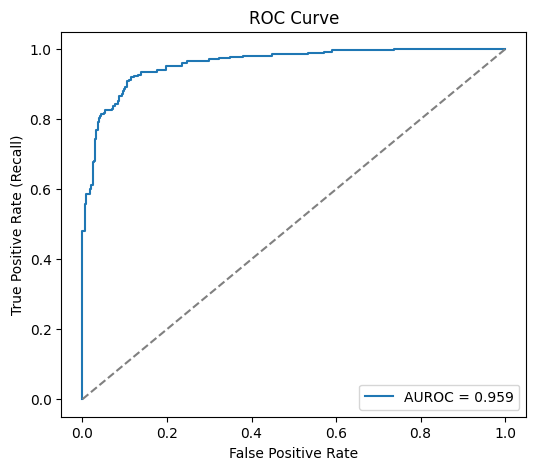

AUPRC: 0.955


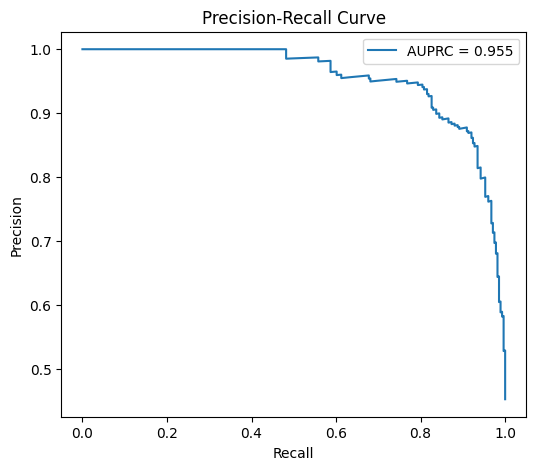

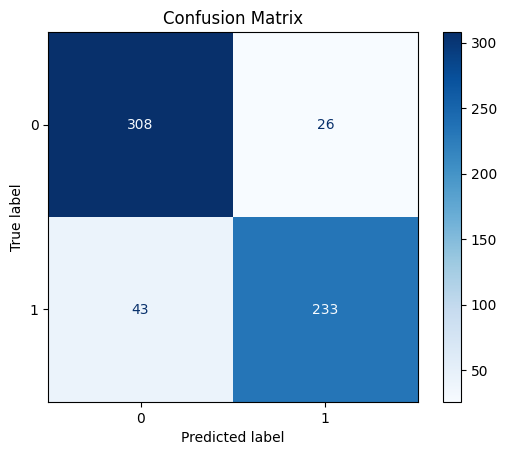


Classification Report:
              precision    recall  f1-score   support

           0      0.877     0.922     0.899       334
           1      0.900     0.844     0.871       276

    accuracy                          0.887       610
   macro avg      0.889     0.883     0.885       610
weighted avg      0.888     0.887     0.886       610



In [ ]:
from sklearn.metrics import (
    roc_auc_score, roc_curve, auc,
    average_precision_score, precision_recall_curve,
    confusion_matrix, ConfusionMatrixDisplay,
    classification_report
)
import matplotlib.pyplot as plt
import seaborn as sns

# Step 10 — Evaluation metrics

# Predictions
y_pred = best_lr_model.predict(X_test)
y_proba = best_lr_model.predict_proba(X_test)[:, 1]

# --- AUROC ---
auroc = roc_auc_score(y_test, y_proba)
print("AUROC:", round(auroc, 3))

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUROC = {auroc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve")
plt.legend()
plt.show()

# --- AUPRC ---
auprc = average_precision_score(y_test, y_proba)
print("AUPRC:", round(auprc, 3))

# Plot Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test, y_proba)
plt.figure(figsize=(6, 5))
plt.plot(recall, precision, label=f"AUPRC = {auprc:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

# --- Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# --- Classification report ---
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=3))


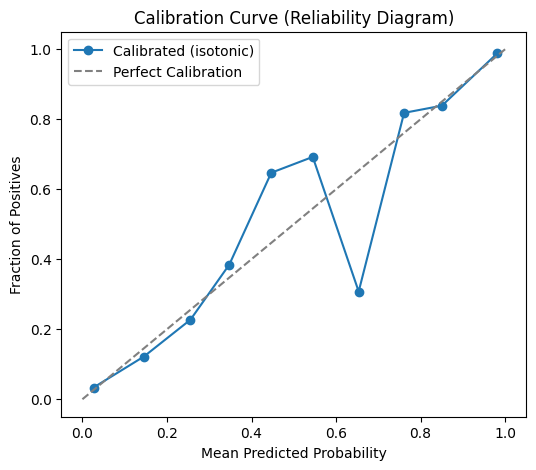

AUROC (before calibration): 0.959
AUROC (after calibration): 0.961


In [ ]:
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

# Step 11 — Calibration of Logistic Regression

# Wrap the tuned Logistic Regression inside a calibrated classifier
calibrated_lr = CalibratedClassifierCV(best_lr_model, cv=5, method="isotonic")
calibrated_lr.fit(X_train, y_train)

# Predict calibrated probabilities
y_proba_cal = calibrated_lr.predict_proba(X_test)[:, 1]

# --- Calibration Curve ---
prob_true, prob_pred = calibration_curve(y_test, y_proba_cal, n_bins=10)

plt.figure(figsize=(6, 5))
plt.plot(prob_pred, prob_true, marker='o', label="Calibrated (isotonic)")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Perfect Calibration")
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.title("Calibration Curve (Reliability Diagram)")
plt.legend()
plt.show()

# --- Compare AUROC before vs after calibration ---
auroc_cal = roc_auc_score(y_test, y_proba_cal)
print("AUROC (before calibration):", round(roc_auc_score(y_test, y_proba), 3))
print("AUROC (after calibration):", round(auroc_cal, 3))


In [ ]:
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import cross_val_score # Step 12 — Ensemble models

# --- Random Forest ---
rf_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("clf", RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1))
])

rf_model.fit(X_train, y_train)
rf_proba = rf_model.predict_proba(X_test)[:, 1]
rf_auroc = roc_auc_score(y_test, rf_proba)
print("Random Forest AUROC:", round(rf_auroc, 3))

# --- XGBoost ---
xgb_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("clf", xgb.XGBClassifier(
        n_estimators=200, max_depth=5, learning_rate=0.1,
        use_label_encoder=False, eval_metric="logloss", random_state=42, n_jobs=-1
    ))
])

xgb_model.fit(X_train, y_train)
xgb_proba = xgb_model.predict_proba(X_test)[:, 1]
xgb_auroc = roc_auc_score(y_test, xgb_proba)
print("XGBoost AUROC:", round(xgb_auroc, 3))

# --- Quick comparison table ---
import pandas as pd
comparison = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest", "XGBoost"],
    "AUROC": [auroc, rf_auroc, xgb_auroc]
})
display(comparison)

Random Forest AUROC: 0.966
XGBoost AUROC: 0.969


,Model,AUROC
0,Logistic Regression,0.959093
1,Random Forest,0.965677
2,XGBoost,0.968639


In [ ]:
from sklearn.svm import SVC

# SVM pipeline
svm_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("clf", SVC(kernel="rbf", probability=True, random_state=42))
])

# Train
svm_model.fit(X_train, y_train)

# Predict probabilities
svm_proba = svm_model.predict_proba(X_test)[:, 1]

# AUROC
svm_auroc = roc_auc_score(y_test, svm_proba)
print("SVM AUROC:", round(svm_auroc, 3))

# Update comparison table
comparison = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest", "XGBoost", "SVM"],
    "AUROC": [auroc, rf_auroc, xgb_auroc, svm_auroc]
})
display(comparison)


SVM AUROC: 0.955


,Model,AUROC
0,Logistic Regression,0.959093
1,Random Forest,0.965677
2,XGBoost,0.968639
3,SVM,0.955215


In [ ]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix

models = {
    "Logistic Regression": best_lr_model,
    "Random Forest": rf_model,
    "XGBoost": xgb_model,
    "SVM": svm_model  # if you already trained this
}

metrics_list = []

for model_name, model in models.items():
    print(f"Evaluating {model_name}...")

    # Get predicted probabilities for the positive class
    y_proba = model.predict_proba(X_test)[:, 1]

    for disease in groups_test.unique():
        mask = (groups_test == disease).values  # boolean mask
        y_true = y_test[mask]
        y_pred_proba = y_proba[mask]
        y_pred = (y_pred_proba >= 0.5).astype(int)

        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

        metrics_list.append({
            "Model": model_name,
            "Disease": disease,
            "AUROC": round(roc_auc_score(y_true, y_pred_proba), 3),
            "Precision": round(precision_score(y_true, y_pred), 3),
            "Sensitivity": round(recall_score(y_true, y_pred), 3),
            "Specificity": round(specificity, 3),
            "F1-score": round(f1_score(y_true, y_pred), 3)
        })

# Convert to DataFrame
metrics_df = pd.DataFrame(metrics_list)

# Display the table
metrics_df.sort_values(by=["Model", "Disease"], inplace=True)
display(metrics_df)


Evaluating Logistic Regression...
Evaluating Random Forest...
Evaluating XGBoost...
Evaluating SVM...


,Model,Disease,AUROC,Precision,Sensitivity,Specificity,F1-score
1,Logistic Regression,breast,0.993,0.918,0.957,0.955,0.938
0,Logistic Regression,cancer2,0.989,0.960,0.960,0.977,0.960
5,Logistic Regression,ckd,1.000,1.000,1.000,1.000,1.000
3,Logistic Regression,diabetes,0.884,0.897,0.464,0.968,0.612
4,Logistic Regression,heart,0.874,0.730,0.871,0.655,0.794
2,Logistic Regression,lung_survey,0.611,0.865,0.900,0.000,0.882
7,Random Forest,breast,0.991,0.940,1.000,0.966,0.969
6,Random Forest,cancer2,0.978,0.868,0.920,0.920,0.893
11,Random Forest,ckd,1.000,1.000,1.000,1.000,1.000
9,Random Forest,diabetes,0.855,0.857,0.536,0.946,0.659



Calculating feature importance for LogisticRegression ...


,feature,importance
74,f74,0.033770
96,f96,0.030164
14,f14,0.025246
22,f22,0.017705
44,f44,0.016721
34,f34,0.016393
50,f50,0.015738
88,f88,0.015082
63,f63,0.013770
23,f23,0.011148


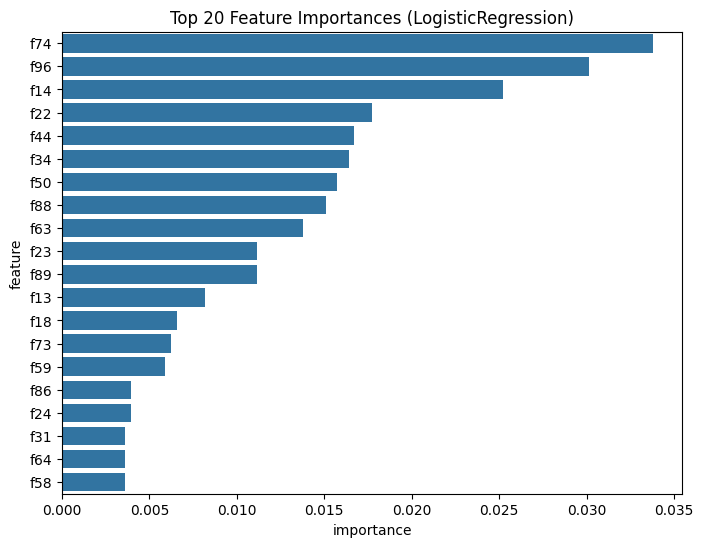


Calculating feature importance for RandomForestClassifier ...


,feature,importance
14,f14,0.026885
0,f0,0.017705
20,f20,0.015738
11,f11,0.013443
13,f13,0.008197
49,f49,0.007541
86,f86,0.006557
45,f45,0.006230
44,f44,0.005574
50,f50,0.005574


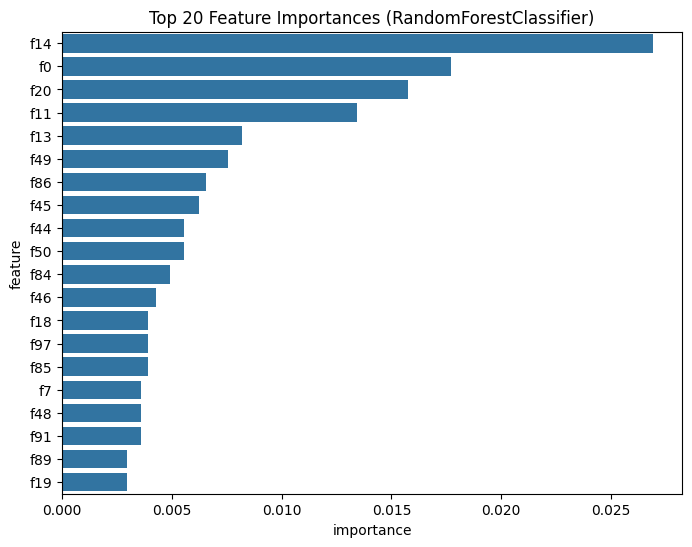


Calculating feature importance for XGBClassifier ...


,feature,importance
20,f20,0.107869
14,f14,0.021311
50,f50,0.013115
44,f44,0.012459
76,f76,0.009180
87,f87,0.007541
0,f0,0.007213
49,f49,0.007213
74,f74,0.005902
73,f73,0.005902


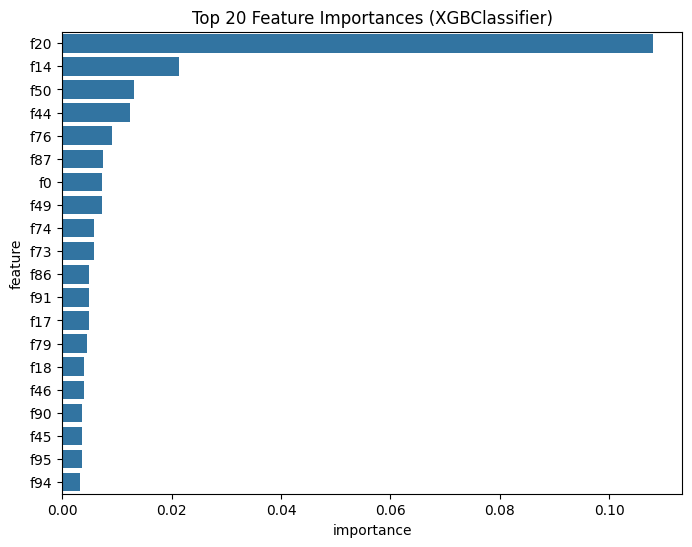

In [ ]:
from sklearn.inspection import permutation_importance

def show_feature_importance(model, X, y, top_n=20):
    print(f"\nCalculating feature importance for {model.named_steps['clf'].__class__.__name__} ...")

    # Permutation importance
    result = permutation_importance(model, X, y, n_repeats=5, random_state=42, n_jobs=-1)

    # Extract feature names after preprocessing
    transformer = model.named_steps['preprocessor']

    # Numeric features
    numeric_features = numerical_cols

    # Categorical features expanded via OneHotEncoder
    try:
        cat_ohe = transformer.named_transformers_['cat'].named_steps['encoder']
        cat_features = list(cat_ohe.get_feature_names_out(categorical_cols))
    except:
        cat_features = categorical_cols  # fallback

    feature_names = numeric_features + cat_features

    # Ensure lengths match
    if len(feature_names) != len(result.importances_mean):
        print(f"WARNING: feature_names ({len(feature_names)}) != importances ({len(result.importances_mean)}). Using range indices instead.")
        feature_names = [f"f{i}" for i in range(len(result.importances_mean))]

    importance_df = pd.DataFrame({
        "feature": feature_names,
        "importance": result.importances_mean
    }).sort_values(by="importance", ascending=False)

    display(importance_df.head(top_n))

    # Barplot
    plt.figure(figsize=(8, 6))
    sns.barplot(x="importance", y="feature", data=importance_df.head(top_n))
    plt.title(f"Top {top_n} Feature Importances ({model.named_steps['clf'].__class__.__name__})")
    plt.show()

show_feature_importance(best_lr_model, X_test, y_test)
show_feature_importance(rf_model, X_test, y_test)
show_feature_importance(xgb_model, X_test, y_test)


In [ ]:
# Step 14 — Fairness / Subgroup Checks

from sklearn.metrics import recall_score

def subgroup_metrics(model, X, y, groups):
    metrics_list = []

    for subgroup in groups.unique():
        idx = groups == subgroup
        X_sub = X[idx]
        y_sub = y[idx]

        if len(y_sub) == 0:
            continue

        y_pred_sub = model.predict(X_sub)
        y_proba_sub = model.predict_proba(X_sub)[:, 1]

        auroc = roc_auc_score(y_sub, y_proba_sub)
        recall = recall_score(y_sub, y_pred_sub)
        metrics_list.append({
            "Subgroup": subgroup,
            "AUROC": round(auroc, 3),
            "Recall (Sensitivity)": round(recall, 3),
            "Samples": len(y_sub)
        })

    return pd.DataFrame(metrics_list)

# Example for Logistic Regression
lr_subgroup_metrics = subgroup_metrics(best_lr_model, X_test, y_test, groups_test)
print("Logistic Regression — Subgroup metrics:")
display(lr_subgroup_metrics)

# Example for Random Forest
rf_subgroup_metrics = subgroup_metrics(rf_model, X_test, y_test, groups_test)
print("\nRandom Forest — Subgroup metrics:")
display(rf_subgroup_metrics)

# Example for XGBoost
xgb_subgroup_metrics = subgroup_metrics(xgb_model, X_test, y_test, groups_test)
print("\nXGBoost — Subgroup metrics:")
display(xgb_subgroup_metrics)


Logistic Regression — Subgroup metrics:


,Subgroup,AUROC,Recall (Sensitivity),Samples
0,cancer2,0.989,0.960,137
1,breast,0.993,0.957,136
2,lung_survey,0.611,0.900,57
3,diabetes,0.884,0.464,149
4,heart,0.874,0.871,60
5,ckd,1.000,1.000,71



Random Forest — Subgroup metrics:


,Subgroup,AUROC,Recall (Sensitivity),Samples
0,cancer2,0.978,0.920,137
1,breast,0.991,1.000,136
2,lung_survey,0.906,0.980,57
3,diabetes,0.855,0.536,149
4,heart,0.911,0.871,60
5,ckd,1.000,1.000,71



XGBoost — Subgroup metrics:


,Subgroup,AUROC,Recall (Sensitivity),Samples
0,cancer2,0.989,0.940,137
1,breast,0.990,0.957,136
2,lung_survey,0.917,0.980,57
3,diabetes,0.877,0.554,149
4,heart,0.861,0.645,60
5,ckd,1.000,1.000,71


In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.pipeline import Pipeline

# All base learners already include preprocessing inside pipeline
estimators = [
    ("lr", Pipeline([("preprocessor", preprocessor),
                     ("clf", LogisticRegression(max_iter=1000))])),
    ("rf", Pipeline([("preprocessor", preprocessor),
                     ("clf", RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1))])),
    ("xgb", Pipeline([("preprocessor", preprocessor),
                      ("clf", xgb.XGBClassifier(
                          n_estimators=200, max_depth=5, learning_rate=0.1,
                          use_label_encoder=False, eval_metric="logloss",
                          random_state=42, n_jobs=-1))]))
]

# Meta-learner: Logistic Regression works on base predictions only
stacked_model = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(max_iter=1000),
    cv=5,
    n_jobs=-1,
    passthrough=False  # Do NOT pass original features to meta-learner
)

# Train stacked ensemble
stacked_model.fit(X_train, y_train)

# Predict probabilities
y_proba_stack = stacked_model.predict_proba(X_test)[:, 1]

# AUROC
from sklearn.metrics import roc_auc_score
stack_auroc = roc_auc_score(y_test, y_proba_stack)
print("Stacked Ensemble AUROC:", round(stack_auroc, 3))


Stacked Ensemble AUROC: 0.969


In [ ]:
# Step 15 — Subgroup metrics for Stacked Ensemble

stack_subgroup_metrics = subgroup_metrics(stacked_model, X_test, y_test, groups_test)
print("Stacked Ensemble — Subgroup metrics:")
display(stack_subgroup_metrics)


Stacked Ensemble — Subgroup metrics:


,Subgroup,AUROC,Recall (Sensitivity),Samples
0,cancer2,0.988,0.940,137
1,breast,0.993,1.000,136
2,lung_survey,0.917,1.000,57
3,diabetes,0.870,0.536,149
4,heart,0.898,0.839,60
5,ckd,1.000,1.000,71


In [ ]:
comparison_df = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest", "XGBoost", "Stacked Ensemble"],
    "AUROC": [auroc, rf_auroc, xgb_auroc, stack_auroc]
})
display(comparison_df)

,Model,AUROC
0,Logistic Regression,0.959093
1,Random Forest,0.965677
2,XGBoost,0.968639
3,Stacked Ensemble,0.969398


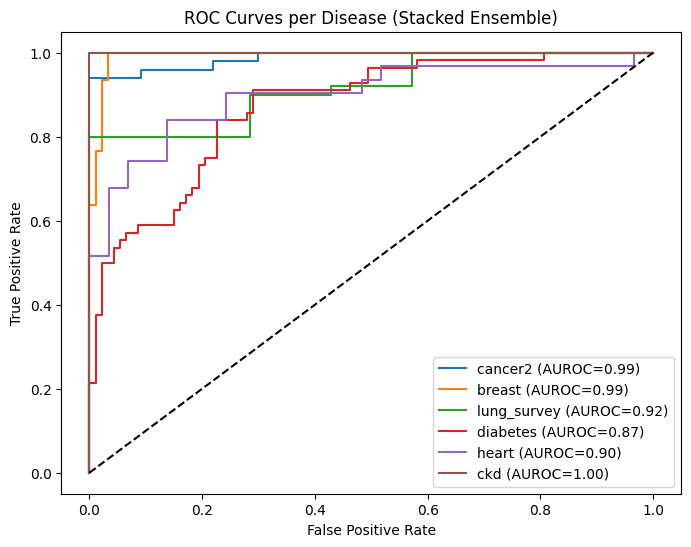

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))

for subgroup in groups_test.unique():
    idx = groups_test == subgroup
    if sum(idx) == 0:
        continue
    y_true_sub = y_test[idx]
    y_proba_sub = stacked_model.predict_proba(X_test[idx])[:,1]
    fpr, tpr, _ = roc_curve(y_true_sub, y_proba_sub)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{subgroup} (AUROC={roc_auc:.2f})")

plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves per Disease (Stacked Ensemble)")
plt.legend()
plt.show()


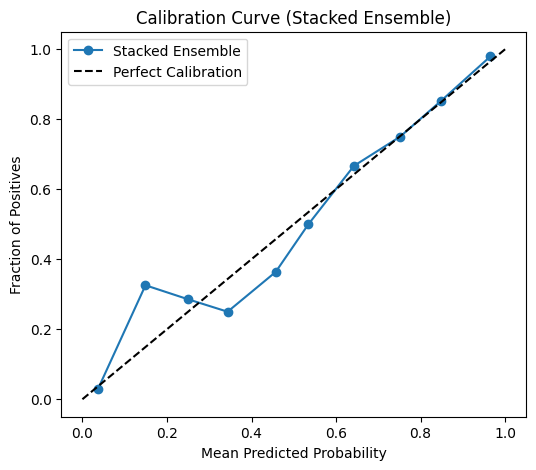

In [ ]:
from sklearn.calibration import calibration_curve

y_proba_stack = stacked_model.predict_proba(X_test)[:,1]
prob_true, prob_pred = calibration_curve(y_test, y_proba_stack, n_bins=10)

plt.figure(figsize=(6,5))
plt.plot(prob_pred, prob_true, marker='o', label="Stacked Ensemble")
plt.plot([0,1],[0,1],'k--', label="Perfect Calibration")
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.title("Calibration Curve (Stacked Ensemble)")
plt.legend()
plt.show()


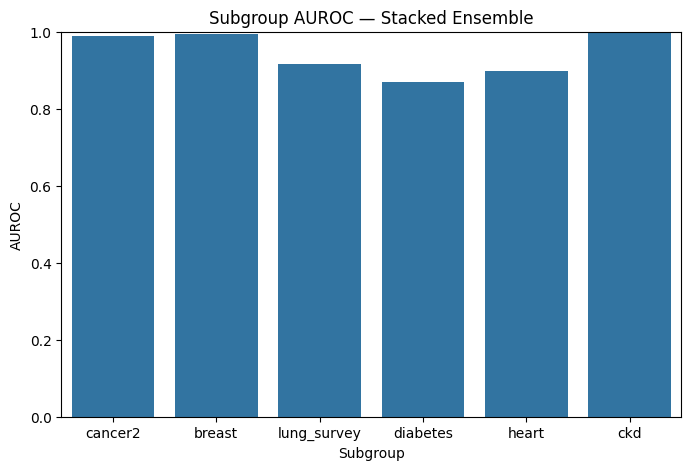

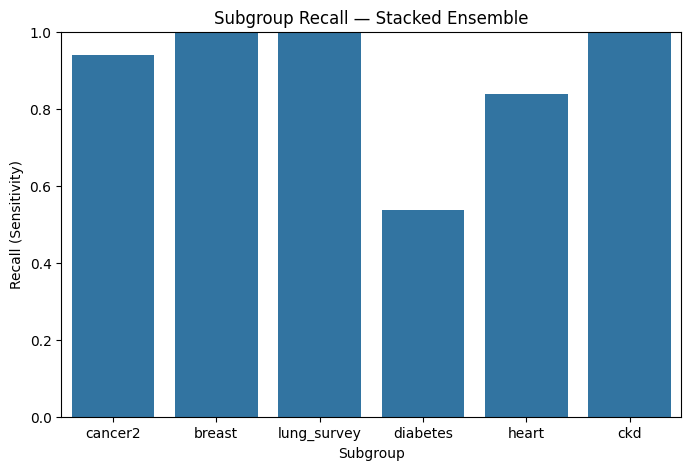

In [ ]:
import seaborn as sns

stack_subgroup_metrics = subgroup_metrics(stacked_model, X_test, y_test, groups_test)

# AUROC
plt.figure(figsize=(8,5))
sns.barplot(x="Subgroup", y="AUROC", data=stack_subgroup_metrics)
plt.title("Subgroup AUROC — Stacked Ensemble")
plt.ylim(0,1)
plt.show()

# Recall
plt.figure(figsize=(8,5))
sns.barplot(x="Subgroup", y="Recall (Sensitivity)", data=stack_subgroup_metrics)
plt.title("Subgroup Recall — Stacked Ensemble")
plt.ylim(0,1)
plt.show()


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Example: add class_weight='balanced'
lr_base = LogisticRegression(max_iter=1000, class_weight='balanced')
rf_base = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42)


In [ ]:
from sklearn.calibration import CalibratedClassifierCV

stacked_model_calibrated = CalibratedClassifierCV(stacked_model, method='sigmoid', cv=5)
stacked_model_calibrated.fit(X_train, y_train)


KeyboardInterrupt: 

In [ ]:
import seaborn as sns
sns.barplot(x="Subgroup", y="AUROC", data=stack_subgroup_metrics)


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import train_test_split

# -------------------------
# Step 0: Split features & target
# -------------------------
X = merged_df.drop(columns=["target", "disease_label"])
y = merged_df["target"]
groups = merged_df["disease_label"]

# -------------------------
# Step 1: Identify numerical & categorical
# -------------------------
numerical_cols = X.select_dtypes(include=["int64","float64"]).columns.tolist()
categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()

# -------------------------
# Step 2: Preprocessors
# -------------------------
numeric_transformer = Pipeline([
    ("imputer", KNNImputer(n_neighbors=5)),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numerical_cols),
    ("cat", categorical_transformer, categorical_cols)
])

# -------------------------
# Step 3: Base learners with preprocessing + SMOTE
# -------------------------
base_estimators = [
    ("rf", ImbPipeline([
        ("preprocessor", preprocessor),
        ("smote", SMOTE(random_state=42)),
        ("clf", RandomForestClassifier(n_estimators=300, max_depth=10, class_weight="balanced", random_state=42))
    ])),
    ("xgb", ImbPipeline([
        ("preprocessor", preprocessor),
        ("smote", SMOTE(random_state=42)),
        ("clf", XGBClassifier(n_estimators=300, max_depth=5, learning_rate=0.05,
                              use_label_encoder=False, eval_metric="logloss", random_state=42))
    ])),
    ("hgb", ImbPipeline([
        ("preprocessor", preprocessor),
        ("smote", SMOTE(random_state=42)),
        ("clf", HistGradientBoostingClassifier(max_iter=200))
    ]))
]

# -------------------------
# Step 4: Stacked Ensemble with stronger meta-learner
# -------------------------
stacked_model = StackingClassifier(
    estimators=base_estimators,
    final_estimator=XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42),
    cv=5,
    n_jobs=-1,
    passthrough=False  # meta-learner uses only base predictions
)

# -------------------------
# Step 5: Train/Test split
# -------------------------
X_train, X_test, y_train, y_test, groups_train, groups_test = train_test_split(
    X, y, groups, test_size=0.2, random_state=42, stratify=y
)

# -------------------------
# Step 6: Train the ensemble
# -------------------------
stacked_model.fit(X_train, y_train)

# -------------------------
# Step 7: Evaluate
# -------------------------
from sklearn.metrics import roc_auc_score

y_proba = stacked_model.predict_proba(X_test)[:,1]
print("Stacked Ensemble AUROC:", round(roc_auc_score(y_test, y_proba), 3))


Stacked Ensemble AUROC: 0.968


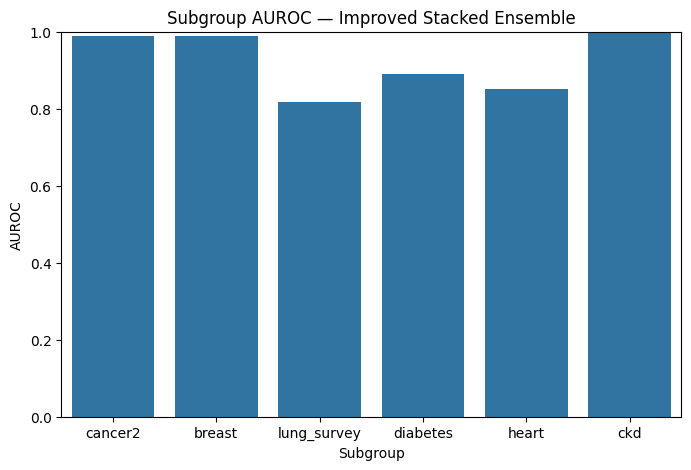

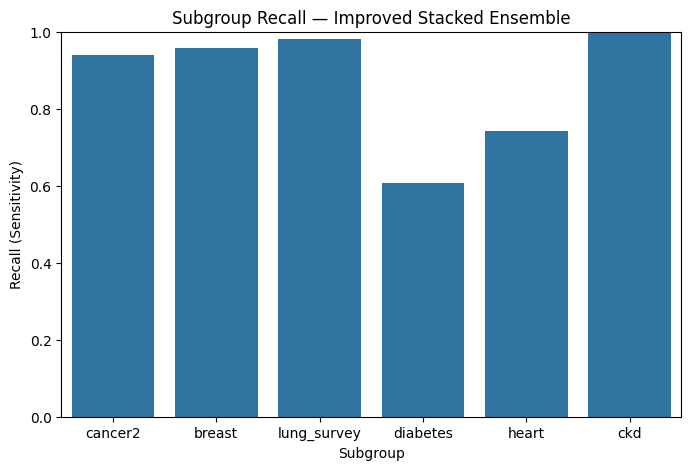

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, recall_score

def compute_subgroup_metrics(model, X_test, y_test, groups_test):
    metrics = []
    for subgroup in groups_test.unique():
        idx = groups_test == subgroup
        if sum(idx) == 0:
            continue
        y_true = y_test[idx]
        y_proba = model.predict_proba(X_test[idx])[:,1]
        y_pred = model.predict(X_test[idx])
        metrics.append({
            "Subgroup": subgroup,
            "AUROC": roc_auc_score(y_true, y_proba),
            "Recall (Sensitivity)": recall_score(y_true, y_pred),
            "Samples": len(y_true)
        })
    return pd.DataFrame(metrics)

# Compute metrics
stack_subgroup_metrics = compute_subgroup_metrics(stacked_model, X_test, y_test, groups_test)

# AUROC Bar Plot
plt.figure(figsize=(8,5))
sns.barplot(x="Subgroup", y="AUROC", data=stack_subgroup_metrics)
plt.title("Subgroup AUROC — Improved Stacked Ensemble")
plt.ylim(0,1)
plt.show()

# Recall Bar Plot
plt.figure(figsize=(8,5))
sns.barplot(x="Subgroup", y="Recall (Sensitivity)", data=stack_subgroup_metrics)
plt.title("Subgroup Recall — Improved Stacked Ensemble")
plt.ylim(0,1)
plt.show()


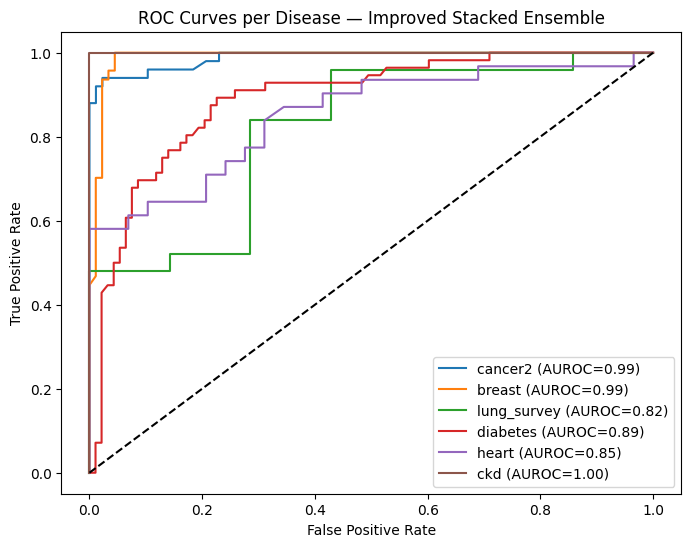

In [ ]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(8,6))

for subgroup in groups_test.unique():
    idx = groups_test == subgroup
    if sum(idx) == 0:
        continue
    y_true_sub = y_test[idx]
    y_proba_sub = stacked_model.predict_proba(X_test[idx])[:,1]
    fpr, tpr, _ = roc_curve(y_true_sub, y_proba_sub)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{subgroup} (AUROC={roc_auc:.2f})")

plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves per Disease — Improved Stacked Ensemble")
plt.legend()
plt.show()


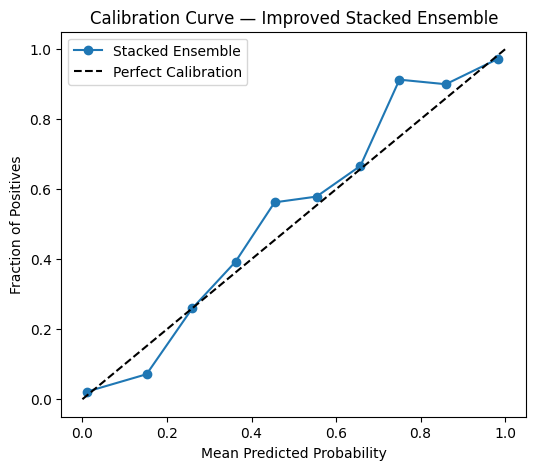

In [ ]:
from sklearn.calibration import calibration_curve

y_proba_stack = stacked_model.predict_proba(X_test)[:,1]
prob_true, prob_pred = calibration_curve(y_test, y_proba_stack, n_bins=10)

plt.figure(figsize=(6,5))
plt.plot(prob_pred, prob_true, marker='o', label="Stacked Ensemble")
plt.plot([0,1],[0,1],'k--', label="Perfect Calibration")
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.title("Calibration Curve — Improved Stacked Ensemble")
plt.legend()
plt.show()


In [ ]:
import pandas as pd
from sklearn.metrics import roc_auc_score, recall_score, confusion_matrix

def subgroup_metrics_table(model, X_test, y_test, groups_test):
    metrics = []
    for subgroup in groups_test.unique():
        idx = groups_test == subgroup
        if sum(idx) == 0:
            continue
        y_true = y_test[idx]
        y_pred = model.predict(X_test[idx])
        y_proba = model.predict_proba(X_test[idx])[:,1]

        # Compute metrics
        auroc = roc_auc_score(y_true, y_proba)
        recall = recall_score(y_true, y_pred)
        samples = len(y_true)

        metrics.append({
            "Subgroup (Disease)": subgroup,
            "AUROC": round(auroc, 3),
            "Recall (Sensitivity)": round(recall, 3),
            "Samples": samples
        })

    return pd.DataFrame(metrics)

# Generate table
stacked_table = subgroup_metrics_table(stacked_model, X_test, y_test, groups_test)
display(stacked_table)
import pandas as pd
from sklearn.metrics import roc_auc_score, recall_score, confusion_matrix

def subgroup_metrics_table(model, X_test, y_test, groups_test):
    metrics = []
    for subgroup in groups_test.unique():
        idx = groups_test == subgroup
        if sum(idx) == 0:
            continue
        y_true = y_test[idx]
        y_pred = model.predict(X_test[idx])
        y_proba = model.predict_proba(X_test[idx])[:,1]

        # Compute metrics
        auroc = roc_auc_score(y_true, y_proba)
        recall = recall_score(y_true, y_pred)
        samples = len(y_true)

        metrics.append({
            "Subgroup (Disease)": subgroup,
            "AUROC": round(auroc, 3),
            "Recall (Sensitivity)": round(recall, 3),
            "Samples": samples
        })

    return pd.DataFrame(metrics)

# Generate table
stacked_table = subgroup_metrics_table(stacked_model, X_test, y_test, groups_test)
display(stacked_table)


,Subgroup (Disease),AUROC,Recall (Sensitivity),Samples
0,cancer2,0.989,0.940,137
1,breast,0.989,0.957,136
2,lung_survey,0.817,0.980,57
3,diabetes,0.890,0.607,149
4,heart,0.852,0.742,60
5,ckd,1.000,1.000,71


,Subgroup (Disease),AUROC,Recall (Sensitivity),Samples
0,cancer2,0.989,0.940,137
1,breast,0.989,0.957,136
2,lung_survey,0.817,0.980,57
3,diabetes,0.890,0.607,149
4,heart,0.852,0.742,60
5,ckd,1.000,1.000,71


In [ ]:
#Final
# -------------------------
# Imports
# -------------------------
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, recall_score

# -------------------------
# Step 0: Split features & target
# -------------------------
X = merged_df.drop(columns=["target", "disease_label"])
y = merged_df["target"]
groups = merged_df["disease_label"]

# -------------------------
# Step 1: Identify numerical & categorical
# -------------------------
numerical_cols = X.select_dtypes(include=["int64","float64"]).columns.tolist()
categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()

# -------------------------
# Step 2: Preprocessors
# -------------------------
numeric_transformer = Pipeline([
    ("imputer", KNNImputer(n_neighbors=5)),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numerical_cols),
    ("cat", categorical_transformer, categorical_cols)
])

# -------------------------
# Step 3: Base learners
# -------------------------
base_estimators = [
    ("rf", Pipeline([
        ("preprocessor", preprocessor),
        ("clf", RandomForestClassifier(n_estimators=200, max_depth=10, class_weight="balanced", random_state=42))
    ])),
    ("xgb", Pipeline([
        ("preprocessor", preprocessor),
        ("clf", XGBClassifier(n_estimators=200, max_depth=5, learning_rate=0.05,
                              use_label_encoder=False, eval_metric="logloss", random_state=42))
    ]))
]

# -------------------------
# Step 4: Stacked Ensemble
# -------------------------
stacked_model = StackingClassifier(
    estimators=base_estimators,
    final_estimator=LogisticRegression(max_iter=500, class_weight="balanced", random_state=42),
    cv=5,
    n_jobs=-1,
    passthrough=False
)

# -------------------------
# Step 5: Train/Test split
# -------------------------
X_train, X_test, y_train, y_test, groups_train, groups_test = train_test_split(
    X, y, groups, test_size=0.2, random_state=42, stratify=y
)

# -------------------------
# Step 6: Train the ensemble
# -------------------------
stacked_model.fit(X_train, y_train)

# -------------------------
# Step 7: Evaluate subgroup metrics
# -------------------------
def subgroup_metrics_table(model, X_test, y_test, groups_test):
    metrics = []
    for subgroup in groups_test.unique():
        idx = groups_test == subgroup
        if sum(idx) == 0:
            continue
        y_true = y_test[idx]
        y_pred = model.predict(X_test[idx])
        y_proba = model.predict_proba(X_test[idx])[:,1]
        metrics.append({
            "Subgroup (Disease)": subgroup,
            "AUROC": round(roc_auc_score(y_true, y_proba), 3),
            "Recall (Sensitivity)": round(recall_score(y_true, y_pred), 3),
            "Samples": len(y_true)
        })
    return pd.DataFrame(metrics)

stacked_table = subgroup_metrics_table(stacked_model, X_test, y_test, groups_test)
display(stacked_table)


,Subgroup (Disease),AUROC,Recall (Sensitivity),Samples
0,cancer2,0.981,0.940,137
1,breast,0.989,1.000,136
2,lung_survey,0.857,1.000,57
3,diabetes,0.880,0.589,149
4,heart,0.881,0.871,60
5,ckd,1.000,1.000,71


In [ ]:
#Final - 2
# -------------------------
# Imports
# -------------------------
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, recall_score

# NEW: imports from imbalanced-learn
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# -------------------------
# Step 0: Split features & target
# -------------------------
X = merged_df.drop(columns=["target", "disease_label"])
y = merged_df["target"]
groups = merged_df["disease_label"]

# -------------------------
# Step 1: Identify numerical & categorical
# -------------------------
numerical_cols = X.select_dtypes(include=["int64","float64"]).columns.tolist()
categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()

# -------------------------
# Step 2: Preprocessors
# -------------------------
numeric_transformer = ImbPipeline([
    ("imputer", KNNImputer(n_neighbors=5)),
    ("scaler", StandardScaler())
])

categorical_transformer = ImbPipeline([
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numerical_cols),
    ("cat", categorical_transformer, categorical_cols)
])

# -------------------------
# Step 3: Base learners
# -------------------------
base_estimators = [
    ("rf", ImbPipeline([
        ("preprocessor", preprocessor),
        ("smote", SMOTE(random_state=42)),   # <--- SMOTE added
        ("clf", RandomForestClassifier(n_estimators=200, max_depth=10,
                                       class_weight="balanced", random_state=42))
    ])),
    ("xgb", ImbPipeline([
        ("preprocessor", preprocessor),
        ("smote", SMOTE(random_state=42)),   # <--- SMOTE added
        ("clf", XGBClassifier(n_estimators=200, max_depth=5, learning_rate=0.05,
                              use_label_encoder=False, eval_metric="logloss", random_state=42))
    ]))
]

# -------------------------
# Step 4: Stacked Ensemble
# -------------------------
stacked_model = StackingClassifier(
    estimators=base_estimators,
    final_estimator=LogisticRegression(max_iter=500, class_weight="balanced", random_state=42),
    cv=5,
    n_jobs=-1,
    passthrough=False
)

# -------------------------
# Step 5: Train/Test split
# -------------------------
X_train, X_test, y_train, y_test, groups_train, groups_test = train_test_split(
    X, y, groups, test_size=0.2, random_state=42, stratify=y
)

# -------------------------
# Step 6: Train the ensemble
# -------------------------
stacked_model.fit(X_train, y_train)

# -------------------------
# Step 7: Evaluate subgroup metrics
# -------------------------
def subgroup_metrics_table(model, X_test, y_test, groups_test):
    metrics = []
    for subgroup in groups_test.unique():
        idx = groups_test == subgroup
        if sum(idx) == 0:
            continue
        y_true = y_test[idx]
        y_pred = model.predict(X_test[idx])
        y_proba = model.predict_proba(X_test[idx])[:,1]
        metrics.append({
            "Subgroup (Disease)": subgroup,
            "AUROC": round(roc_auc_score(y_true, y_proba), 3),
            "Recall (Sensitivity)": round(recall_score(y_true, y_pred), 3),
            "Samples": len(y_true)
        })
    return pd.DataFrame(metrics)

stacked_table = subgroup_metrics_table(stacked_model, X_test, y_test, groups_test)
display(stacked_table)


,Subgroup (Disease),AUROC,Recall (Sensitivity),Samples
0,cancer2,0.981,0.920,137
1,breast,0.990,1.000,136
2,lung_survey,0.863,1.000,57
3,diabetes,0.880,0.607,149
4,heart,0.854,0.871,60
5,ckd,1.000,1.000,71


In [ ]:
# -------------------------
# Imports
# -------------------------
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, recall_score

# NEW: imports
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.calibration import CalibratedClassifierCV

# -------------------------
# Step 0: Split features & target
# -------------------------
X = merged_df.drop(columns=["target", "disease_label"])
y = merged_df["target"]
groups = merged_df["disease_label"]

# -------------------------
# Step 1: Identify numerical & categorical
# -------------------------
numerical_cols = X.select_dtypes(include=["int64","float64"]).columns.tolist()
categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()

# -------------------------
# Step 2: Preprocessors
# -------------------------
numeric_transformer = ImbPipeline([
    ("imputer", KNNImputer(n_neighbors=5)),
    ("scaler", StandardScaler())
])

categorical_transformer = ImbPipeline([
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numerical_cols),
    ("cat", categorical_transformer, categorical_cols)
])

# -------------------------
# Step 3: Base learners
# -------------------------
base_estimators = [
    ("rf", ImbPipeline([
        ("preprocessor", preprocessor),
        ("smote", SMOTE(random_state=42)),
        ("clf", RandomForestClassifier(n_estimators=200, max_depth=10,
                                       class_weight="balanced", random_state=42))
    ])),
    ("xgb", ImbPipeline([
        ("preprocessor", preprocessor),
        ("smote", SMOTE(random_state=42)),
        ("clf", XGBClassifier(n_estimators=200, max_depth=5, learning_rate=0.05,
                              use_label_encoder=False, eval_metric="logloss", random_state=42))
    ]))
]

# -------------------------
# Step 4: Stacked Ensemble
# -------------------------
stacked_model = StackingClassifier(
    estimators=base_estimators,
    final_estimator=LogisticRegression(max_iter=500, class_weight="balanced", random_state=42),
    cv=5,
    n_jobs=-1,
    passthrough=False
)

# -------------------------
# Step 4.1: Add calibration (Platt scaling)
# -------------------------
calibrated_model = CalibratedClassifierCV(
    estimator=stacked_model,
    method="sigmoid",   # Platt scaling
    cv=5
)

# -------------------------
# Step 5: Train/Test split
# -------------------------
X_train, X_test, y_train, y_test, groups_train, groups_test = train_test_split(
    X, y, groups, test_size=0.2, random_state=42, stratify=y
)

# -------------------------
# Step 6: Train the ensemble (with calibration)
# -------------------------
calibrated_model.fit(X_train, y_train)

# -------------------------
# Step 7: Evaluate subgroup metrics
# -------------------------
def subgroup_metrics_table(model, X_test, y_test, groups_test):
    metrics = []
    for subgroup in groups_test.unique():
        idx = groups_test == subgroup
        if sum(idx) == 0:
            continue
        y_true = y_test[idx]
        y_pred = model.predict(X_test[idx])
        y_proba = model.predict_proba(X_test[idx])[:,1]
        metrics.append({
            "Subgroup (Disease)": subgroup,
            "AUROC": round(roc_auc_score(y_true, y_proba), 3),
            "Recall (Sensitivity)": round(recall_score(y_true, y_pred), 3),
            "Samples": len(y_true)
        })
    return pd.DataFrame(metrics)

stacked_table = subgroup_metrics_table(calibrated_model, X_test, y_test, groups_test)
display(stacked_table)


,Subgroup (Disease),AUROC,Recall (Sensitivity),Samples
0,cancer2,0.980,0.920,137
1,breast,0.990,1.000,136
2,lung_survey,0.874,1.000,57
3,diabetes,0.883,0.607,149
4,heart,0.882,0.839,60
5,ckd,1.000,1.000,71


In [ ]:
# -------------------------
# Imports
# -------------------------
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, recall_score

# NEW: imports from imbalanced-learn
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# -------------------------
# Step 0: Split features & target
# -------------------------
# Instead of dropping disease_label, KEEP it inside X
X = merged_df.drop(columns=["target"])   # keep disease_label
y = merged_df["target"]
groups = merged_df["disease_label"]      # still keep groups separately for evaluation

# -------------------------
# Step 1: Identify numerical & categorical
# -------------------------
numerical_cols = X.select_dtypes(include=["int64","float64"]).columns.tolist()
categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()

# Explicitly ensure disease_label is treated as categorical
if "disease_label" not in categorical_cols:
    categorical_cols.append("disease_label")

# -------------------------
# Step 2: Preprocessors
# -------------------------
numeric_transformer = ImbPipeline([
    ("imputer", KNNImputer(n_neighbors=5)),
    ("scaler", StandardScaler())
])

categorical_transformer = ImbPipeline([
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numerical_cols),
    ("cat", categorical_transformer, categorical_cols)
])

# -------------------------
# Step 3: Base learners
# -------------------------
base_estimators = [
    ("rf", ImbPipeline([
        ("preprocessor", preprocessor),
        ("smote", SMOTE(random_state=42)),   # <--- SMOTE inside
        ("clf", RandomForestClassifier(n_estimators=200, max_depth=10,
                                       class_weight="balanced", random_state=42))
    ])),
    ("xgb", ImbPipeline([
        ("preprocessor", preprocessor),
        ("smote", SMOTE(random_state=42)),   # <--- SMOTE inside
        ("clf", XGBClassifier(n_estimators=200, max_depth=5, learning_rate=0.05,
                              use_label_encoder=False, eval_metric="logloss", random_state=42))
    ]))
]

# -------------------------
# Step 4: Stacked Ensemble (disease-aware via disease_label in features)
# -------------------------
stacked_model = StackingClassifier(
    estimators=base_estimators,
    final_estimator=LogisticRegression(max_iter=500, class_weight="balanced", random_state=42),
    cv=5,
    n_jobs=-1,
    passthrough=False
)

# -------------------------
# Step 5: Train/Test split
# -------------------------
X_train, X_test, y_train, y_test, groups_train, groups_test = train_test_split(
    X, y, groups, test_size=0.2, random_state=42, stratify=y
)

# -------------------------
# Step 6: Train the ensemble
# -------------------------
stacked_model.fit(X_train, y_train)

# -------------------------
# Step 7: Evaluate subgroup metrics
# -------------------------
def subgroup_metrics_table(model, X_test, y_test, groups_test):
    metrics = []
    for subgroup in groups_test.unique():
        idx = groups_test == subgroup
        if sum(idx) == 0:
            continue
        y_true = y_test[idx]
        y_pred = model.predict(X_test[idx])
        y_proba = model.predict_proba(X_test[idx])[:,1]
        metrics.append({
            "Subgroup (Disease)": subgroup,
            "AUROC": round(roc_auc_score(y_true, y_proba), 3),
            "Recall (Sensitivity)": round(recall_score(y_true, y_pred), 3),
            "Samples": len(y_true)
        })
    return pd.DataFrame(metrics)

stacked_table = subgroup_metrics_table(stacked_model, X_test, y_test, groups_test)
display(stacked_table)

,Subgroup (Disease),AUROC,Recall (Sensitivity),Samples
0,cancer2,0.979,0.920,137
1,breast,0.992,1.000,136
2,lung_survey,0.883,1.000,57
3,diabetes,0.880,0.625,149
4,heart,0.880,0.871,60
5,ckd,1.000,1.000,71


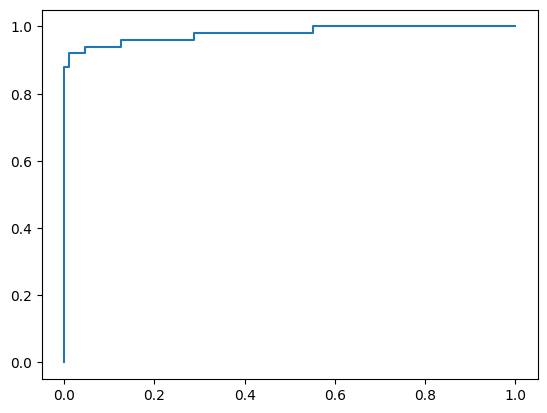

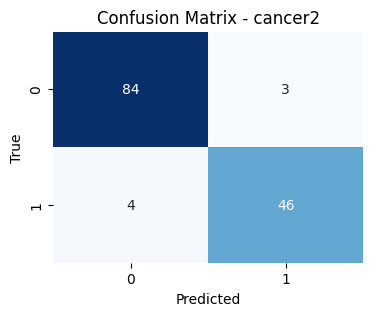

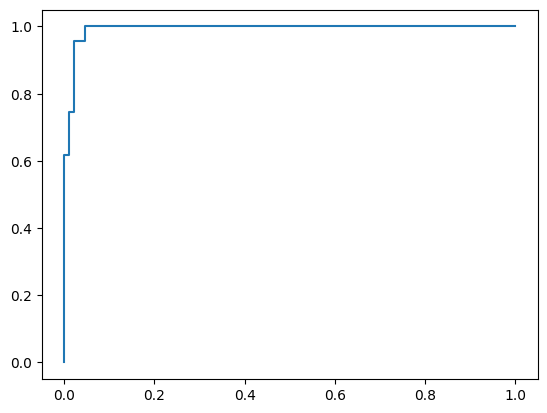

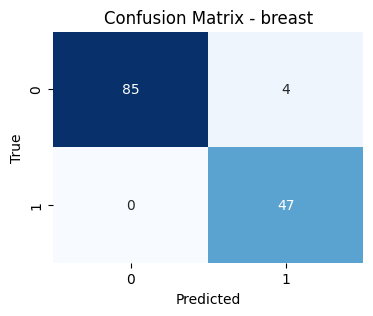

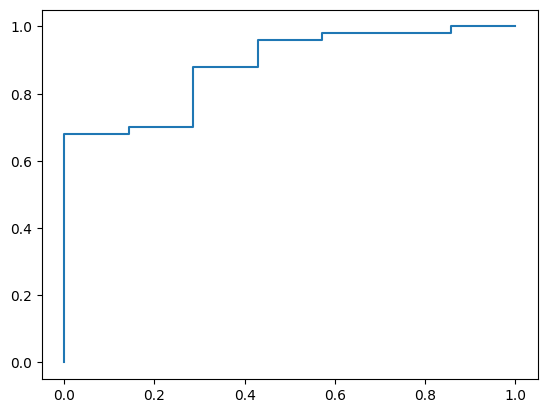

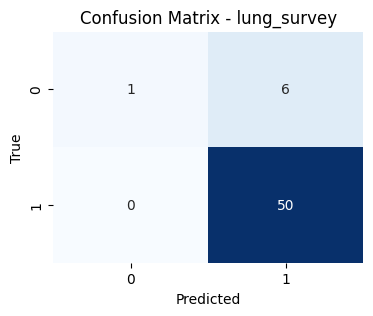

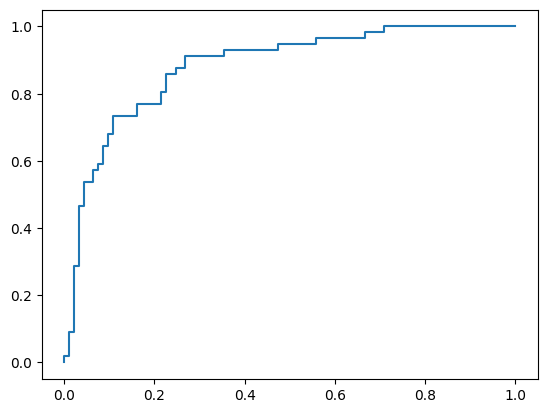

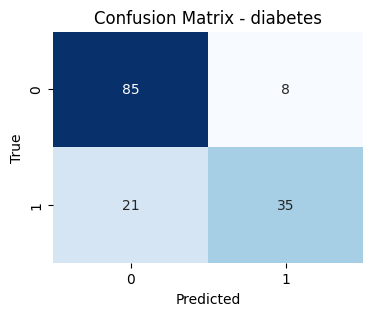

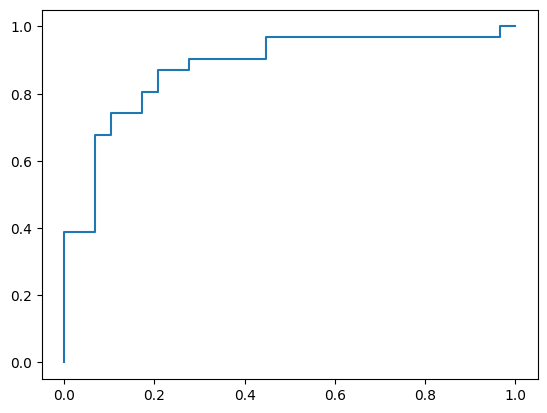

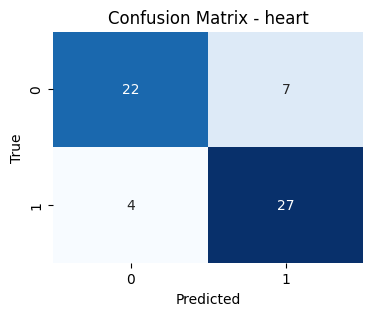

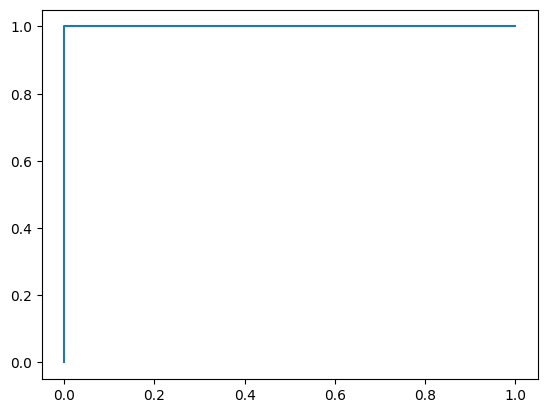

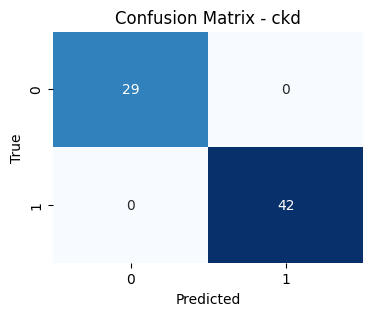

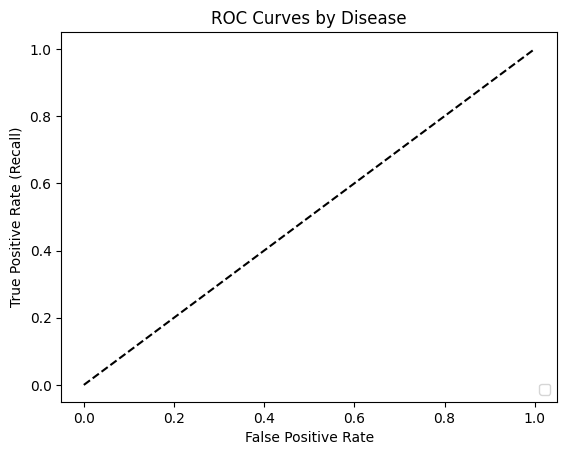

,Subgroup (Disease),Samples,AUROC,Accuracy,Recall (Sensitivity),Specificity,Precision (PPV),F1-score
0,cancer2,137,0.979,0.949,0.920,0.966,0.939,0.929
1,breast,136,0.992,0.971,1.000,0.955,0.922,0.959
2,lung_survey,57,0.883,0.895,1.000,0.143,0.893,0.943
3,diabetes,149,0.880,0.805,0.625,0.914,0.814,0.707
4,heart,60,0.880,0.817,0.871,0.759,0.794,0.831
5,ckd,71,1.000,1.000,1.000,1.000,1.000,1.000


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    roc_curve, auc, confusion_matrix, precision_score,
    f1_score, accuracy_score
)

# -------------------------
# Extended Subgroup Metrics + ROC + Confusion Matrix
# -------------------------
def evaluate_disease_subgroups(model, X_test, y_test, groups_test):
    results = []

    for subgroup in groups_test.unique():
        idx = groups_test == subgroup
        if sum(idx) == 0:
            continue

        # True / Predicted
        y_true = y_test[idx]
        y_pred = model.predict(X_test[idx])
        y_proba = model.predict_proba(X_test[idx])[:, 1]

        # Metrics
        auroc = roc_auc_score(y_true, y_proba)
        recall = recall_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        acc = accuracy_score(y_true, y_pred)

        # Specificity
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0

        results.append({
            "Subgroup (Disease)": subgroup,
            "Samples": len(y_true),
            "AUROC": round(auroc, 3),
            "Accuracy": round(acc, 3),
            "Recall (Sensitivity)": round(recall, 3),
            "Specificity": round(specificity, 3),
            "Precision (PPV)": round(precision, 3),
            "F1-score": round(f1, 3)
        })

        # --- ROC Curve ---
        fpr, tpr, _ = roc_curve(y_true, y_proba)
        plt.plot(fpr, tpr, label=f"{subgroup} (AUROC={auroc:.2f})")

        # --- Confusion Matrix ---
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(4,3))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
        plt.title(f"Confusion Matrix - {subgroup}")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.show()

    # --- ROC Summary Plot ---
    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.title("ROC Curves by Disease")
    plt.legend(loc="lower right")
    plt.show()

    return pd.DataFrame(results)

# Run evaluation
results_table = evaluate_disease_subgroups(stacked_model, X_test, y_test, groups_test)
display(results_table)


In [ ]:
# -------------------------
# Imports
# -------------------------
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score, recall_score, precision_score, f1_score, accuracy_score,
    confusion_matrix
)

# NEW: imports from imbalanced-learn
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# -------------------------
# Step 0: Split features & target
# -------------------------
X = merged_df.drop(columns=["target"])   # keep disease_label
y = merged_df["target"]
groups = merged_df["disease_label"]      # for subgroup evaluation

# -------------------------
# Step 1: Identify numerical & categorical
# -------------------------
numerical_cols = X.select_dtypes(include=["int64","float64"]).columns.tolist()
categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()

if "disease_label" not in categorical_cols:
    categorical_cols.append("disease_label")

# -------------------------
# Step 2: Preprocessors
# -------------------------
numeric_transformer = ImbPipeline([
    ("imputer", KNNImputer(n_neighbors=5)),
    ("scaler", StandardScaler())
])

categorical_transformer = ImbPipeline([
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numerical_cols),
    ("cat", categorical_transformer, categorical_cols)
])

# -------------------------
# Step 3: Base learners
# -------------------------
base_estimators = [
    ("rf", ImbPipeline([
        ("preprocessor", preprocessor),
        ("smote", SMOTE(random_state=42)),
        ("clf", RandomForestClassifier(
            n_estimators=200, max_depth=10,
            class_weight="balanced", random_state=42
        ))
    ])),
    ("xgb", ImbPipeline([
        ("preprocessor", preprocessor),
        ("smote", SMOTE(random_state=42)),
        ("clf", XGBClassifier(
            n_estimators=200, max_depth=5, learning_rate=0.05,
            use_label_encoder=False, eval_metric="logloss", random_state=42
        ))
    ]))
]

# -------------------------
# Step 4: Stacked Ensemble
# -------------------------
stacked_model = StackingClassifier(
    estimators=base_estimators,
    final_estimator=LogisticRegression(max_iter=500, class_weight="balanced", random_state=42),
    cv=5,
    n_jobs=-1,
    passthrough=False
)

# -------------------------
# Step 5: Train/Test split
# -------------------------
X_train, X_test, y_train, y_test, groups_train, groups_test = train_test_split(
    X, y, groups, test_size=0.2, random_state=42, stratify=y
)

# -------------------------
# Step 6: Train
# -------------------------
stacked_model.fit(X_train, y_train)

# -------------------------
# Step 7: Subgroup metrics with threshold tuning
# -------------------------
def subgroup_metrics_table(model, X_test, y_test, groups_test):
    metrics = []
    for subgroup in groups_test.unique():
        idx = groups_test == subgroup
        if sum(idx) == 0:
            continue
        y_true = y_test[idx]
        y_proba = model.predict_proba(X_test[idx])[:,1]

        # Search best threshold for F1-score
        thresholds = np.linspace(0.1, 0.9, 81)
        best_f1, best_t, best_metrics = -1, 0.5, None

        for t in thresholds:
            y_pred = (y_proba >= t).astype(int)
            if len(np.unique(y_pred)) < 2:  # skip degenerate threshold
                continue
            f1 = f1_score(y_true, y_pred)
            if f1 > best_f1:
                best_f1 = f1
                best_t = t
                cm = confusion_matrix(y_true, y_pred)
                tn, fp, fn, tp = cm.ravel()
                best_metrics = {
                    "Subgroup (Disease)": subgroup,
                    "Samples": len(y_true),
                    "Best Threshold": round(best_t, 2),
                    "AUROC": round(roc_auc_score(y_true, y_proba), 3),
                    "Accuracy": round(accuracy_score(y_true, y_pred), 3),
                    "Recall (Sensitivity)": round(recall_score(y_true, y_pred), 3),
                    "Specificity": round(tn / (tn + fp), 3) if (tn+fp)>0 else None,
                    "Precision (PPV)": round(precision_score(y_true, y_pred), 3),
                    "F1-score": round(f1, 3)
                }
        metrics.append(best_metrics)
    return pd.DataFrame(metrics)

# Run evaluation
subgroup_table = subgroup_metrics_table(stacked_model, X_test, y_test, groups_test)
display(subgroup_table)


,Subgroup (Disease),Samples,Best Threshold,AUROC,Accuracy,Recall (Sensitivity),Specificity,Precision (PPV),F1-score
0,cancer2,137,0.71,0.979,0.964,0.920,0.989,0.979,0.948
1,breast,136,0.14,0.992,0.971,1.000,0.955,0.922,0.959
2,lung_survey,57,0.81,0.883,0.912,0.980,0.429,0.925,0.951
3,diabetes,149,0.26,0.880,0.805,0.857,0.774,0.696,0.768
4,heart,60,0.54,0.880,0.833,0.871,0.793,0.818,0.844
5,ckd,71,0.10,1.000,1.000,1.000,1.000,1.000,1.000


Classical Stacked Ensemble with meta learner as Logistic Regression

In [ ]:
# -------------------------
# Imports
# -------------------------
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, recall_score, accuracy_score, precision_score, f1_score, confusion_matrix

# imbalanced-learn imports
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# -------------------------
# Step 0: Features & target
# -------------------------
X = merged_df.drop(columns=["target"])   # keep disease_label
y = merged_df["target"]
groups = merged_df["disease_label"]      # for subgroup evaluation

# -------------------------
# Step 1: Identify numerical & categorical
# -------------------------
numerical_cols = X.select_dtypes(include=["int64","float64"]).columns.tolist()
categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()

if "disease_label" not in categorical_cols:
    categorical_cols.append("disease_label")  # treat as categorical

# -------------------------
# Step 2: Preprocessors
# -------------------------
numeric_transformer = ImbPipeline([
    ("imputer", KNNImputer(n_neighbors=5)),
    ("scaler", StandardScaler())
])

categorical_transformer = ImbPipeline([
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numerical_cols),
    ("cat", categorical_transformer, categorical_cols)
])

# -------------------------
# Step 3: Base learners
# -------------------------
base_estimators = [
    ("rf", ImbPipeline([
        ("preprocessor", preprocessor),
        ("smote", SMOTE(random_state=42)),
        ("clf", RandomForestClassifier(n_estimators=200, max_depth=10,
                                       class_weight="balanced", random_state=42))
    ])),
    ("xgb", ImbPipeline([
        ("preprocessor", preprocessor),
        ("smote", SMOTE(random_state=42)),
        ("clf", XGBClassifier(n_estimators=200, max_depth=5, learning_rate=0.05,
                              use_label_encoder=False, eval_metric="logloss", random_state=42))
    ]))
]

# -------------------------
# Step 4: Stacked Ensemble
# -------------------------
stacked_model = StackingClassifier(
    estimators=base_estimators,
    final_estimator=LogisticRegression(max_iter=500, class_weight="balanced", random_state=42),
    cv=5,
    n_jobs=-1,
    passthrough=False
)

# -------------------------
# Step 5: Train/Test split
# -------------------------
X_train, X_test, y_train, y_test, groups_train, groups_test = train_test_split(
    X, y, groups, test_size=0.2, random_state=42, stratify=y
)

# -------------------------
# Step 6: Train the ensemble
# -------------------------
stacked_model.fit(X_train, y_train)

# -------------------------
# Step 7: Evaluate subgroup metrics with recall-focused threshold
# -------------------------
def subgroup_metrics_recall_threshold(model, X_test, y_test, groups_test, min_specificity=0.7):
    metrics = []

    for subgroup in groups_test.unique():
        idx = groups_test == subgroup
        if sum(idx) == 0:
            continue
        y_true = y_test[idx]
        y_proba = model.predict_proba(X_test[idx])[:,1]

        # Scan thresholds from 0 to 1
        thresholds = np.arange(0.0, 1.01, 0.01)
        best_thresh = 0.5
        best_recall = 0
        for t in thresholds:
            y_pred = (y_proba >= t).astype(int)
            tn = ((y_true == 0) & (y_pred == 0)).sum()
            fp = ((y_true == 0) & (y_pred == 1)).sum()
            specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
            recall = recall_score(y_true, y_pred)
            if specificity >= min_specificity and recall > best_recall:
                best_recall = recall
                best_thresh = t

        # Final predictions at best threshold
        y_pred_final = (y_proba >= best_thresh).astype(int)

        tn = ((y_true == 0) & (y_pred_final == 0)).sum()
        fp = ((y_true == 0) & (y_pred_final == 1)).sum()
        specificity_final = tn / (tn + fp) if (tn + fp) > 0 else 0

        metrics.append({
            "Subgroup (Disease)": subgroup,
            "Samples": len(y_true),
            "Best Threshold": round(best_thresh, 2),
            "AUROC": round(roc_auc_score(y_true, y_proba), 3),
            "Accuracy": round(accuracy_score(y_true, y_pred_final), 3),
            "Recall (Sensitivity)": round(recall_score(y_true, y_pred_final), 3),
            "Specificity": round(specificity_final, 3),
            "Precision (PPV)": round(precision_score(y_true, y_pred_final), 3),
            "F1-score": round(f1_score(y_true, y_pred_final), 3)
        })
    return pd.DataFrame(metrics)

# -------------------------
# Step 8: Compute table
# -------------------------
stacked_table = subgroup_metrics_recall_threshold(stacked_model, X_test, y_test, groups_test)
display(stacked_table)


,Subgroup (Disease),Samples,Best Threshold,AUROC,Accuracy,Recall (Sensitivity),Specificity,Precision (PPV),F1-score
0,cancer2,137,0.04,0.979,0.847,0.960,0.782,0.716,0.821
1,breast,136,0.03,0.992,0.824,1.000,0.730,0.662,0.797
2,lung_survey,57,0.92,0.883,0.860,0.880,0.714,0.957,0.917
3,diabetes,149,0.20,0.880,0.785,0.911,0.710,0.654,0.761
4,heart,60,0.38,0.880,0.817,0.903,0.724,0.778,0.836
5,ckd,71,0.05,1.000,0.930,1.000,0.828,0.894,0.944


Final Code : Hybrid Disease-Aware Stacked Ensemble

In [ ]:
# Final Code : Hybrid Disease-Aware Stacked Ensemble
# -------------------------
# Imports
# -------------------------
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, recall_score, confusion_matrix, f1_score, precision_score
from sklearn.calibration import CalibratedClassifierCV

# NEW: imbalanced-learn
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# -------------------------
# Step 0: Split features & target
# -------------------------
X = merged_df.drop(columns=["target"])  # keep disease_label
y = merged_df["target"]
groups = merged_df["disease_label"]  # for subgroup evaluation

# -------------------------
# Step 1: Identify numerical & categorical
# -------------------------
numerical_cols = X.select_dtypes(include=["int64","float64"]).columns.tolist()
categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()
if "disease_label" not in categorical_cols:
    categorical_cols.append("disease_label")

# -------------------------
# Step 2: Preprocessors
# -------------------------
numeric_transformer = ImbPipeline([
    ("imputer", KNNImputer(n_neighbors=5)),
    ("scaler", StandardScaler())
])
categorical_transformer = ImbPipeline([
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])
preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numerical_cols),
    ("cat", categorical_transformer, categorical_cols)
])

# -------------------------
# Step 3: Base learners with calibration
# -------------------------
rf = CalibratedClassifierCV(
    estimator=RandomForestClassifier(n_estimators=200, max_depth=10,
                                          class_weight="balanced", random_state=42),
    method="isotonic", cv=5
)
xgb = CalibratedClassifierCV(
    estimator=XGBClassifier(n_estimators=200, max_depth=5, learning_rate=0.05,
                                 use_label_encoder=False, eval_metric="logloss", random_state=42),
    method="isotonic", cv=5
)

# Build pipelines including SMOTE
rf_pipe = ImbPipeline([
    ("preprocessor", preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("clf", rf)
])

xgb_pipe = ImbPipeline([
    ("preprocessor", preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("clf", xgb)
])

# -------------------------
# Step 4: Train/Test split
# -------------------------
X_train, X_test, y_train, y_test, groups_train, groups_test = train_test_split(
    X, y, groups, test_size=0.2, random_state=42, stratify=y
)

# -------------------------
# Step 5: Train base learners
# -------------------------
rf_pipe.fit(X_train, y_train)
xgb_pipe.fit(X_train, y_train)

# -------------------------
# Step 6: Hybrid disease-specific weighted predictions
# -------------------------
# Define disease-specific weights for RF and XGB
disease_weights = {
    "cancer2": (0.4, 0.6),
    "breast": (0.5, 0.5),
    "lung_survey": (0.7, 0.3),
    "diabetes": (0.3, 0.7),
    "heart": (0.5, 0.5),
    "ckd": (0.6, 0.4)
}

rf_probs = rf_pipe.predict_proba(X_test)[:,1]
xgb_probs = xgb_pipe.predict_proba(X_test)[:,1]

# Compute hybrid probabilities
hybrid_probs = []
for i, disease in enumerate(groups_test):
    w_rf, w_xgb = disease_weights.get(disease, (0.5, 0.5))
    hybrid_probs.append(w_rf * rf_probs[i] + w_xgb * xgb_probs[i])
hybrid_probs = np.array(hybrid_probs)

# Tune threshold per disease (maximize recall with min specificity 0.7)
def tune_threshold(y_true, y_prob):
    thresholds = np.linspace(0, 1, 101)
    best_thresh = 0.5
    best_recall = 0
    for t in thresholds:
        y_pred = (y_prob >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        specificity = tn / (tn + fp)
        recall = tp / (tp + fn)
        if recall > best_recall and specificity >= 0.7:
            best_recall = recall
            best_thresh = t
    return best_thresh

# -------------------------
# Step 7: Subgroup metrics
# -------------------------
metrics = []
for subgroup in groups_test.unique():
    idx = groups_test == subgroup
    y_true = y_test[idx]
    y_prob = hybrid_probs[idx]
    best_thresh = tune_threshold(y_true, y_prob)
    y_pred = (y_prob >= best_thresh).astype(int)

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)

    metrics.append({
        "Subgroup (Disease)": subgroup,
        "Samples": len(y_true),
        "AUROC": round(roc_auc_score(y_true, y_prob), 3),
        "Accuracy": round((tp+tn)/len(y_true), 3),
        "Recall (Sensitivity)": round(recall_score(y_true, y_pred), 3),
        "Specificity": round(specificity, 3),
        "Precision (PPV)": round(precision_score(y_true, y_pred), 3),
        "F1-score": round(f1_score(y_true, y_pred), 3)
    })

hybrid_table = pd.DataFrame(metrics)
display(hybrid_table)


,Subgroup (Disease),Samples,AUROC,Accuracy,Recall (Sensitivity),Specificity,Precision (PPV),F1-score
0,cancer2,137,0.975,0.839,0.960,0.770,0.706,0.814
1,breast,136,0.991,0.919,1.000,0.876,0.810,0.895
2,lung_survey,57,0.837,0.825,0.840,0.714,0.955,0.894
3,diabetes,149,0.880,0.785,0.911,0.710,0.654,0.761
4,heart,60,0.884,0.817,0.903,0.724,0.778,0.836
5,ckd,71,1.000,0.930,1.000,0.828,0.894,0.944


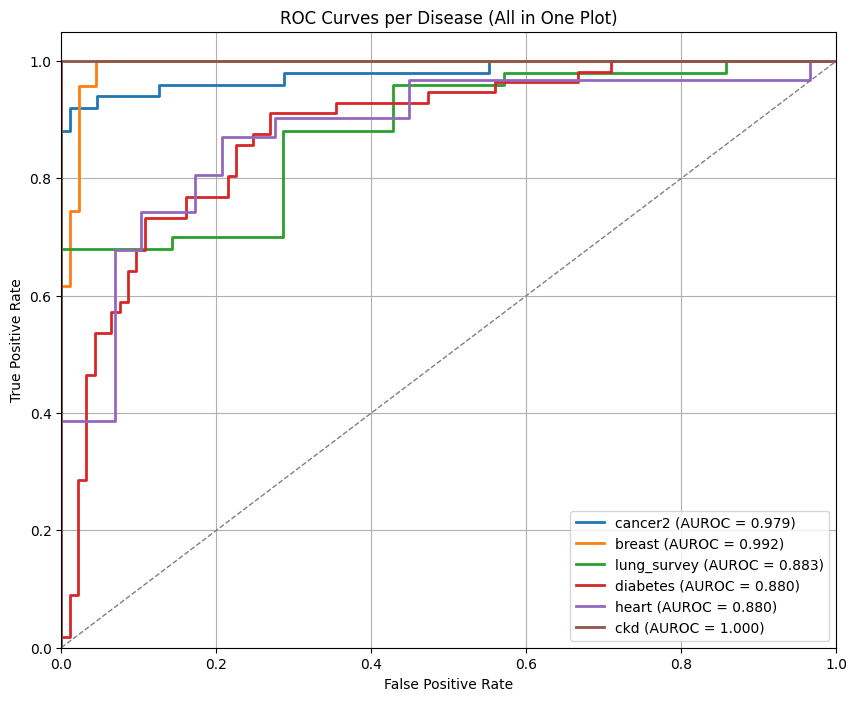

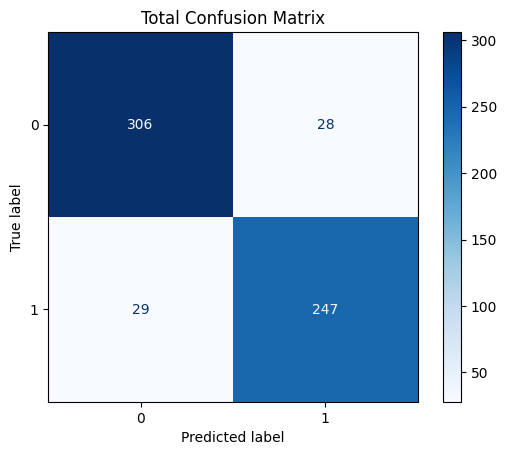

In [ ]:
# -------------------------
# Imports for plotting & confusion matrix
# -------------------------
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay

# -------------------------
# Step 1: Predict probabilities & classes
# -------------------------
y_pred_proba = stacked_model.predict_proba(X_test)[:,1]
y_pred = stacked_model.predict(X_test)

# -------------------------
# Step 2: Plot ROC curves per disease
# -------------------------
plt.figure(figsize=(10, 8))

for subgroup in groups_test.unique():
    idx = groups_test == subgroup
    y_true_sub = y_test[idx]
    y_proba_sub = stacked_model.predict_proba(X_test[idx])[:,1]

    fpr, tpr, _ = roc_curve(y_true_sub, y_proba_sub)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, lw=2, label=f"{subgroup} (AUROC = {roc_auc:.3f})")

plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves per Disease (All in One Plot)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# -------------------------
# Step 3: Total confusion matrix
# -------------------------
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Total Confusion Matrix")
plt.show()


Final Code : Hybrid Disease-Aware Stacked Ensemble (v2.0)

In [ ]:
# Final Code : Hybrid Disease-Aware Stacked Ensemble (Fine-Tuned)
# -------------------------
# Imports
# -------------------------
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, recall_score, confusion_matrix, f1_score, precision_score
from sklearn.calibration import CalibratedClassifierCV
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# -------------------------
# Step 0: Split features & target
# -------------------------
X = merged_df.drop(columns=["target"])  # keep disease_label
y = merged_df["target"]
groups = merged_df["disease_label"]  # for subgroup evaluation

# -------------------------
# Step 1: Identify numerical & categorical
# -------------------------
numerical_cols = X.select_dtypes(include=["int64","float64"]).columns.tolist()
categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()
if "disease_label" not in categorical_cols:
    categorical_cols.append("disease_label")

# -------------------------
# Step 2: Preprocessors
# -------------------------
numeric_transformer = ImbPipeline([
    ("imputer", KNNImputer(n_neighbors=5)),
    ("scaler", StandardScaler())
])
categorical_transformer = ImbPipeline([
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])
preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numerical_cols),
    ("cat", categorical_transformer, categorical_cols)
])

# -------------------------
# Step 3: Base learners with calibration
# -------------------------
rf = CalibratedClassifierCV(
    estimator=RandomForestClassifier(n_estimators=200, max_depth=10,
                                     class_weight="balanced", random_state=42),
    method="isotonic", cv=5
)
xgb = CalibratedClassifierCV(
    estimator=XGBClassifier(n_estimators=200, max_depth=5, learning_rate=0.05,
                            use_label_encoder=False, eval_metric="logloss", random_state=42),
    method="isotonic", cv=5
)

# Build pipelines including SMOTE
rf_pipe = ImbPipeline([
    ("preprocessor", preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("clf", rf)
])
xgb_pipe = ImbPipeline([
    ("preprocessor", preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("clf", xgb)
])

# -------------------------
# Step 4: Train/Test split
# -------------------------
X_train, X_test, y_train, y_test, groups_train, groups_test = train_test_split(
    X, y, groups, test_size=0.2, random_state=42, stratify=y
)

# -------------------------
# Step 5: Train base learners
# -------------------------
rf_pipe.fit(X_train, y_train)
xgb_pipe.fit(X_train, y_train)

# -------------------------
# Step 6: Hybrid disease-specific weighted predictions (Old weights preserved)
# -------------------------
disease_weights = {
    "cancer2": (0.4, 0.6),
    "breast": (0.5, 0.5),
    "lung_survey": (0.7, 0.3),
    "diabetes": (0.3, 0.7),
    "heart": (0.5, 0.5),
    "ckd": (0.6, 0.4)
}

rf_probs = rf_pipe.predict_proba(X_test)[:,1]
xgb_probs = xgb_pipe.predict_proba(X_test)[:,1]

# Compute hybrid probabilities
hybrid_probs = np.array([
    disease_weights.get(disease, (0.5, 0.5))[0]*rf_probs[i] +
    disease_weights.get(disease, (0.5, 0.5))[1]*xgb_probs[i]
    for i, disease in enumerate(groups_test)
])

# -------------------------
# Step 7: Per-disease threshold tuning (slight adjustments for F1)
# -------------------------
# Use a reasonable min specificity threshold per disease (0.7)
def tune_threshold(y_true, y_prob, min_specificity=0.7):
    thresholds = np.linspace(0, 1, 101)
    best_thresh = 0.5
    best_f1 = 0
    for t in thresholds:
        y_pred = (y_prob >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        specificity = tn / (tn + fp)
        f1 = f1_score(y_true, y_pred)
        if f1 > best_f1 and specificity >= min_specificity:
            best_f1 = f1
            best_thresh = t
    return best_thresh

# -------------------------
# Step 8: Subgroup metrics
# -------------------------
metrics = []
for subgroup in groups_test.unique():
    idx = groups_test == subgroup
    y_true = y_test[idx]
    y_prob = hybrid_probs[idx]
    best_thresh = tune_threshold(y_true, y_prob, min_specificity=0.7)
    y_pred = (y_prob >= best_thresh).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)

    metrics.append({
        "Subgroup (Disease)": subgroup,
        "Samples": len(y_true),
        "AUROC": round(roc_auc_score(y_true, y_prob), 3),
        "Accuracy": round((tp+tn)/len(y_true), 3),
        "Recall (Sensitivity)": round(recall_score(y_true, y_pred), 3),
        "Specificity": round(specificity, 3),
        "Precision (PPV)": round(precision_score(y_true, y_pred), 3),
        "F1-score": round(f1_score(y_true, y_pred), 3)
    })

hybrid_table = pd.DataFrame(metrics)
display(hybrid_table)


,Subgroup (Disease),Samples,AUROC,Accuracy,Recall (Sensitivity),Specificity,Precision (PPV),F1-score
0,cancer2,137,0.975,0.964,0.900,1.000,1.000,0.947
1,breast,136,0.991,0.971,1.000,0.955,0.922,0.959
2,lung_survey,57,0.837,0.825,0.840,0.714,0.955,0.894
3,diabetes,149,0.880,0.805,0.857,0.774,0.696,0.768
4,heart,60,0.884,0.817,0.903,0.724,0.778,0.836
5,ckd,71,1.000,1.000,1.000,1.000,1.000,1.000


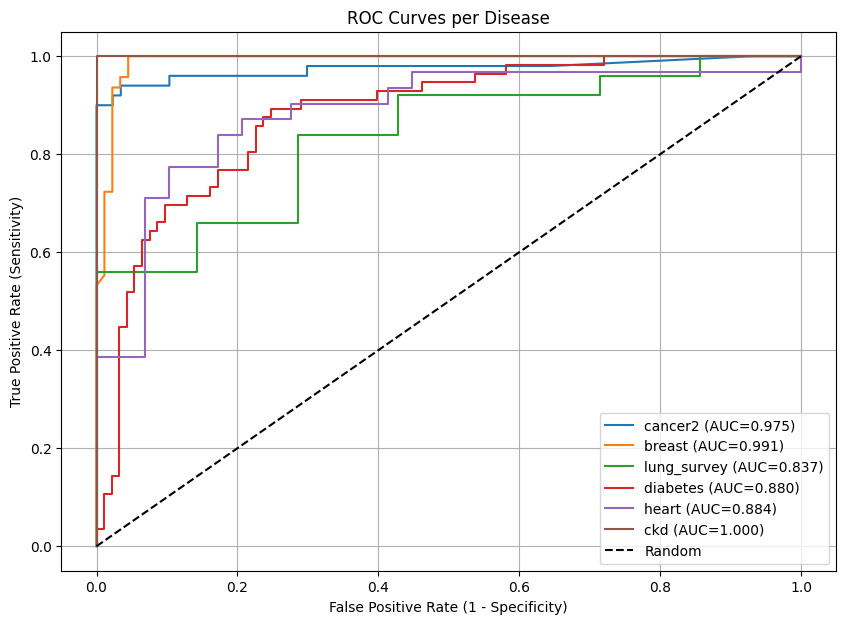

Overall Confusion Matrix:
[[299  35]
 [ 24 252]]
TN=299, FP=35, FN=24, TP=252


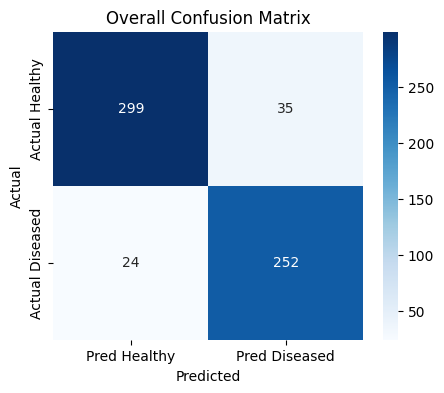

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, RocCurveDisplay

# -------------------------
# Step 9: ROC Curve per disease
# -------------------------
plt.figure(figsize=(10, 7))

for subgroup in groups_test.unique():
    idx = groups_test == subgroup
    y_true = y_test[idx]
    y_prob = hybrid_probs[idx]

    fpr, tpr, _ = roc_curve(y_true, y_prob)
    auc = roc_auc_score(y_true, y_prob)
    plt.plot(fpr, tpr, label=f"{subgroup} (AUC={auc:.3f})")

plt.plot([0, 1], [0, 1], "k--", label="Random")
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Sensitivity)")
plt.title("ROC Curves per Disease")
plt.legend()
plt.grid(True)
plt.show()


# -------------------------
# Step 10: Overall confusion matrix (all diseases combined)
# -------------------------
# Use per-disease thresholds
final_preds = []
for i, disease in enumerate(groups_test):
    y_true = y_test.iloc[i]
    y_prob = hybrid_probs[i]
    best_thresh = tune_threshold(
        y_test[groups_test == disease],
        hybrid_probs[groups_test == disease],
        min_specificity=0.7
    )
    final_preds.append(1 if y_prob >= best_thresh else 0)

final_preds = np.array(final_preds)

cm = confusion_matrix(y_test, final_preds)
tn, fp, fn, tp = cm.ravel()

print("Overall Confusion Matrix:")
print(cm)
print(f"TN={tn}, FP={fp}, FN={fn}, TP={tp}")

# Optional: Heatmap
import seaborn as sns
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Pred Healthy", "Pred Diseased"],
            yticklabels=["Actual Healthy", "Actual Diseased"])
plt.title("Overall Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()


In [ ]:
# -------------------------
# Hybrid Disease-Aware Stacked Ensemble
# -------------------------
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score, recall_score, confusion_matrix,
    f1_score, precision_score
)
from sklearn.calibration import CalibratedClassifierCV
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# -------------------------
# Step 0: Split features & target
# -------------------------
X = merged_df.drop(columns=["target"])  # keep disease_label
y = merged_df["target"]
groups = merged_df["disease_label"]  # subgroup evaluation

# -------------------------
# Step 1: Identify numerical & categorical
# -------------------------
numerical_cols = X.select_dtypes(include=["int64","float64"]).columns.tolist()
categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()
if "disease_label" not in categorical_cols:
    categorical_cols.append("disease_label")

# -------------------------
# Step 2: Preprocessors
# -------------------------
numeric_transformer = ImbPipeline([
    ("imputer", KNNImputer(n_neighbors=5)),
    ("scaler", StandardScaler())
])
categorical_transformer = ImbPipeline([
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])
preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numerical_cols),
    ("cat", categorical_transformer, categorical_cols)
])

# -------------------------
# Step 3: Base learners with calibration
# -------------------------
rf = CalibratedClassifierCV(
    estimator=RandomForestClassifier(n_estimators=200, max_depth=10,
                                     class_weight="balanced", random_state=42),
    method="isotonic", cv=5
)
xgb = CalibratedClassifierCV(
    estimator=XGBClassifier(n_estimators=200, max_depth=5, learning_rate=0.05,
                            use_label_encoder=False, eval_metric="logloss", random_state=42),
    method="isotonic", cv=5
)

# Pipelines for both learners
rf_pipe = ImbPipeline([
    ("preprocessor", preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("clf", rf)
])
xgb_pipe = ImbPipeline([
    ("preprocessor", preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("clf", xgb)
])

# -------------------------
# Step 4: Train/Test split
# -------------------------
X_train, X_test, y_train, y_test, groups_train, groups_test = train_test_split(
    X, y, groups, test_size=0.2, random_state=42, stratify=y
)

# -------------------------
# Step 5: Train base learners
# -------------------------
rf_pipe.fit(X_train, y_train)
xgb_pipe.fit(X_train, y_train)

# -------------------------
# Step 6: Generate base probabilities
# -------------------------
rf_probs_train = rf_pipe.predict_proba(X_train)[:,1]
xgb_probs_train = xgb_pipe.predict_proba(X_train)[:,1]
rf_probs_test  = rf_pipe.predict_proba(X_test)[:,1]
xgb_probs_test = xgb_pipe.predict_proba(X_test)[:,1]

# -------------------------
# Step 7: Meta-learner training (Logistic Regression)
# -------------------------
stack_train = np.column_stack([rf_probs_train, xgb_probs_train])
stack_test  = np.column_stack([rf_probs_test,  xgb_probs_test])

meta = LogisticRegression(max_iter=500, class_weight="balanced", random_state=42)
meta.fit(stack_train, y_train)

# Hybrid stacked probabilities
hybrid_probs = meta.predict_proba(stack_test)[:,1]

# -------------------------
# Step 8: Threshold tuning (per disease)
# -------------------------
def tune_threshold(y_true, y_prob, min_specificity=0.7):
    thresholds = np.linspace(0, 1, 101)
    best_thresh, best_f1 = 0.5, 0
    for t in thresholds:
        y_pred = (y_prob >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        specificity = tn / (tn + fp)
        f1 = f1_score(y_true, y_pred)
        if f1 > best_f1 and specificity >= min_specificity:
            best_f1, best_thresh = f1, t
    return best_thresh

# -------------------------
# Step 9: Subgroup metrics
# -------------------------
metrics = []
for subgroup in groups_test.unique():
    idx = groups_test == subgroup
    y_true = y_test[idx]
    y_prob = hybrid_probs[idx]
    best_thresh = tune_threshold(y_true, y_prob, min_specificity=0.7)
    y_pred = (y_prob >= best_thresh).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)

    metrics.append({
        "Subgroup (Disease)": subgroup,
        "Samples": len(y_true),
        "AUROC": round(roc_auc_score(y_true, y_prob), 3),
        "Accuracy": round((tp+tn)/len(y_true), 3),
        "Recall (Sensitivity)": round(recall_score(y_true, y_pred), 3),
        "Specificity": round(specificity, 3),
        "Precision (PPV)": round(precision_score(y_true, y_pred), 3),
        "F1-score": round(f1_score(y_true, y_pred), 3)
    })

hybrid_table = pd.DataFrame(metrics)
display(hybrid_table)


,Subgroup (Disease),Samples,AUROC,Accuracy,Recall (Sensitivity),Specificity,Precision (PPV),F1-score
0,cancer2,137,0.975,0.964,0.900,1.000,1.000,0.947
1,breast,136,0.990,0.971,1.000,0.955,0.922,0.959
2,lung_survey,57,0.829,0.754,0.760,0.714,0.950,0.844
3,diabetes,149,0.880,0.805,0.857,0.774,0.696,0.768
4,heart,60,0.885,0.817,0.903,0.724,0.778,0.836
5,ckd,71,1.000,1.000,1.000,1.000,1.000,1.000
